# Statistical Methods in Astrophysics Exercises

## Week 04: Parameter Estimation

### Personal Information

**Name:** physnya



### Exercise 1: Location of the lighthouse

A lighthouse is located at an unknown position $\alpha$ along a straight coastline. The distance from the lighthouse to the coastline is $\beta = 1$. The lighthouse emits light in random directions, and the light hits the coast at positions $x_k$.

See the lecture slides for the illustration of the problem.

#### Question 1.1: Sample mean and standard deviation

**Tasks:**
1. Simulate 10000 flash positions $x_k$ from the lighthouse, with the true position $\alpha_{\rm true} = 0$.
2. For each $N_{\rm flash} = 2^n$, $n = 3, 4, \dots, 13$, compute the sample mean $\mu_{\rm sp}$ and sample standard deviation $\sigma_{\rm sp}$ of the first $N_{\rm flash}$ positions.
3. Plot the sample means and standard deviations as a function of $N_{\rm flash}$ using appropriate axes scales.

In [5]:
# NOTE: Run this cell in the first place
# Load packages for numerical calculations and plotting
import numpy as np
import matplotlib.pyplot as plt
# Enable inline plotting in Jupyter notebooks
plt.rcParams['figure.figsize'] = (9.6, 5.4)
plt.rcParams['figure.dpi'] = 300
%matplotlib inline
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')
# 由于设置了图片的高 dpi 和字体，所以编译速度变慢.

In [6]:
def sim_lighthouse_flashes(num, alpha, beta = 1, seed = 42):
    """Simulate positions of lighthouse flashes on the shoreline
    Args:
        num : int, number of flashes to simulate
        alpha : float, lighthouse position on x-axis
        beta : float, lighthouse position on y-axis (default: 1)
        seed : int, random seed for reproducibility (default: 42)
    Returns: array of x positions of the flashes
    """
    rng = np.random.default_rng(seed)
    theta = rng.uniform(-np.pi/2, np.pi/2, num)
    x = alpha + beta * np.tan(theta)
    return x

In [7]:
# Set the random seed
# NOTE: EDIT HERE to insert your seed as the seed
seed = 2024011182
nsample = 10000
alpha_true = 0

# Simulate lighthouse flashes
flash_data = sim_lighthouse_flashes(nsample, alpha_true, seed = seed)

In [8]:
nflash = [2**n for n in range(3, 14)] # Number of flashes to consider
alpha_sample_mean = [] # Store sample mean estimates of alpha
alpha_sample_sigma = [] # Store sample standard deviation estimates of alpha

for n in nflash:
    sample = flash_data[:n]
    # NOTE: EDIT BELOW to compute the sample mean and standard deviation
    alpha_sample_mean.append(np.mean(sample))
    alpha_sample_sigma.append(np.std(sample))

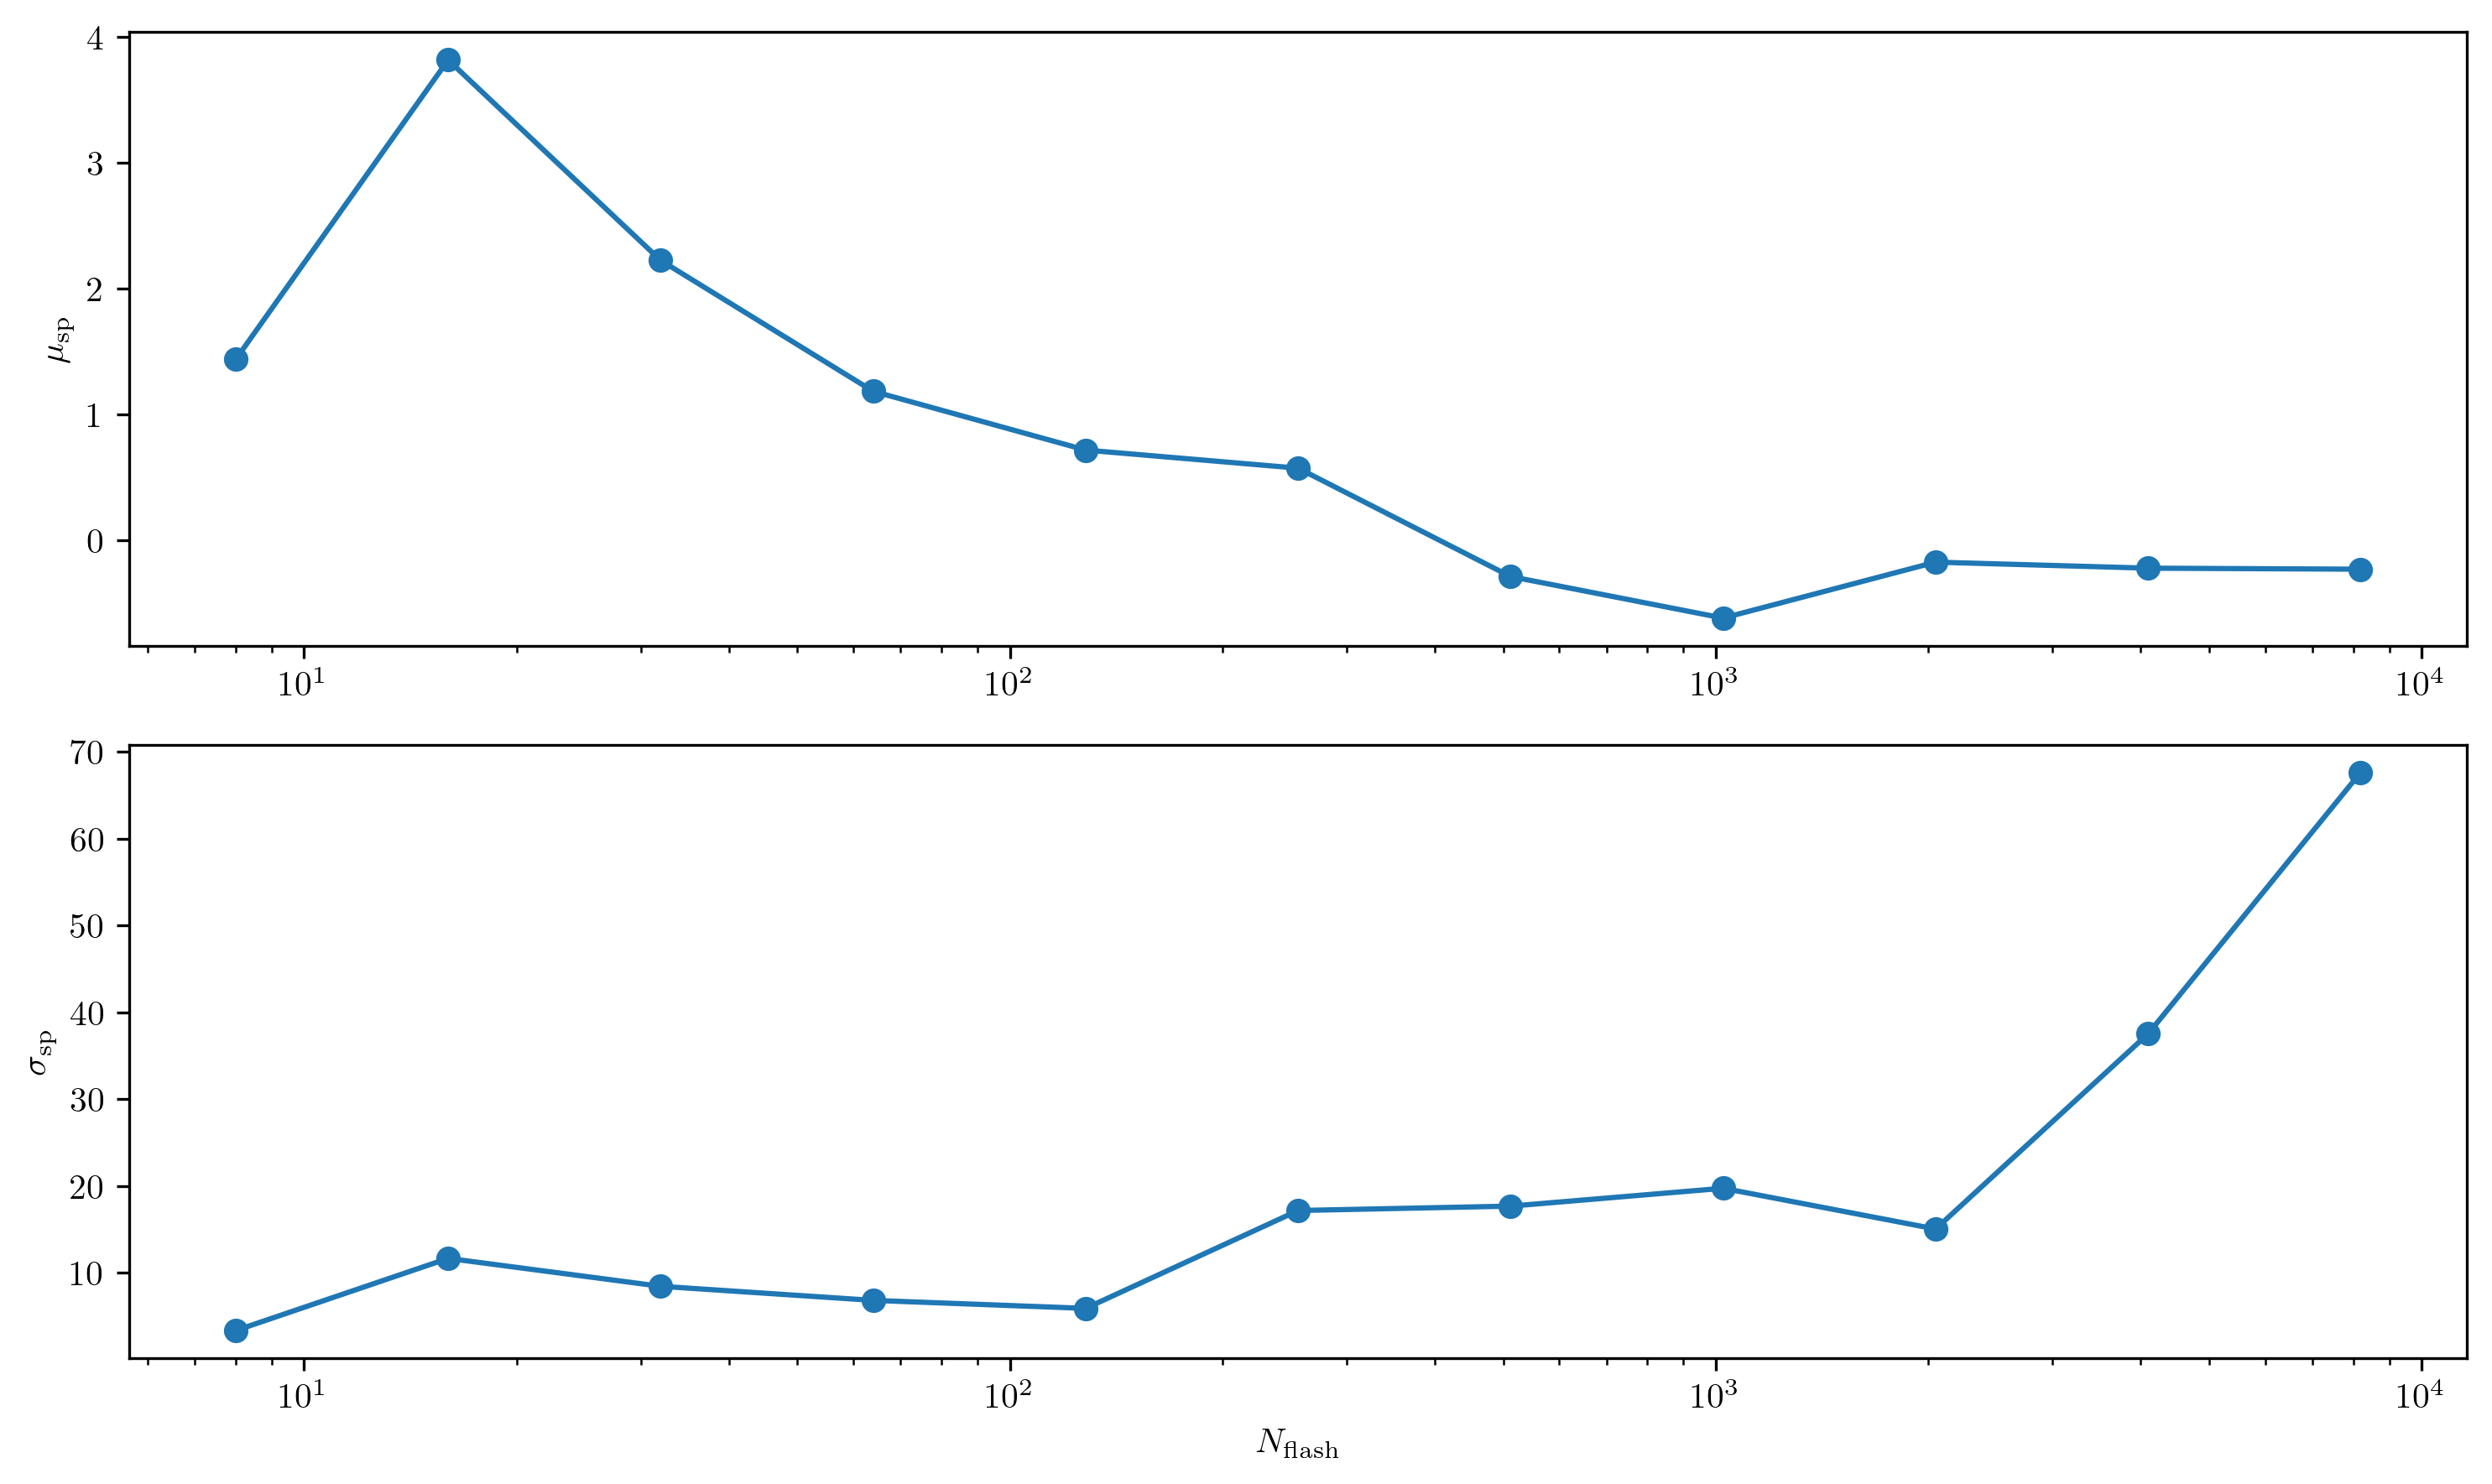

In [9]:
plt.figure(figsize = (10, 6))
ax = [plt.subplot2grid((2, 1), (i, 0)) for i in range(2)]
plt.subplots_adjust(hspace = 0)

# Plot the sample mean and standard deviation estimates of alpha
ax[0].plot(nflash, alpha_sample_mean, 'o-')
ax[1].plot(nflash, alpha_sample_sigma, 'o-')

# NOTE: EDIT BELOW to set axes scales and ranges
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_ylabel(r'$\mu_{\rm sp}$')
ax[1].set_ylabel(r'$\sigma_{\rm sp}$')
ax[1].set_xlabel(r'$N_{\rm flash}$')

plt.tight_layout()

#### Question 1.2: Bayesian posterior

Let us choose a flat prior for $\alpha$ in the range $[-50, 50]$. The likelihood function for a set of $N_{\rm flash}$ observations $\{x_k\}$ is given in the lecture slides.

**Tasks:**
1. For the same $N_{\rm flash}$ values as in Question 1.1, compute the posterior distribution of $\alpha$ on a grid of $\alpha$ values in the prior range $[-50, 50]$.
2. Plot the posterior distributions of $\alpha$ for different $N_{\rm flash}$ values.

In [10]:
def posterior_lighthouse(data, beta = 1):
    """Compute the posterior distribution of alpha given the data.
    Args:
        data : array, observed positions of lighthouse flashes
        beta : float, lighthouse position on y-axis (default: 1)
    Returns:
        alpha : array, grid of alpha values
        posterior : array, posterior distribution of alpha
    """
    alpha = np.linspace(-50, 50, 10000)
    # NOTE: EDIT BELOW to compute the posterior distribution of alpha
    loglike = [np.log(beta**2 + (d - alpha)**2) for d in data]
    loglike = -np.sum(loglike, axis = 0)
    loglike -= np.max(loglike) # for numerical stability

    posterior = np.exp(loglike)
    posterior /= np.trapezoid(posterior, alpha) # normalize the posterior
    return alpha, posterior

In [11]:
posteriors = []     # Store posterior distributions for different N_flash

for n in nflash:
    sample = flash_data[:n]
    alpha_grid, posterior = posterior_lighthouse(sample)
    posteriors.append(posterior)

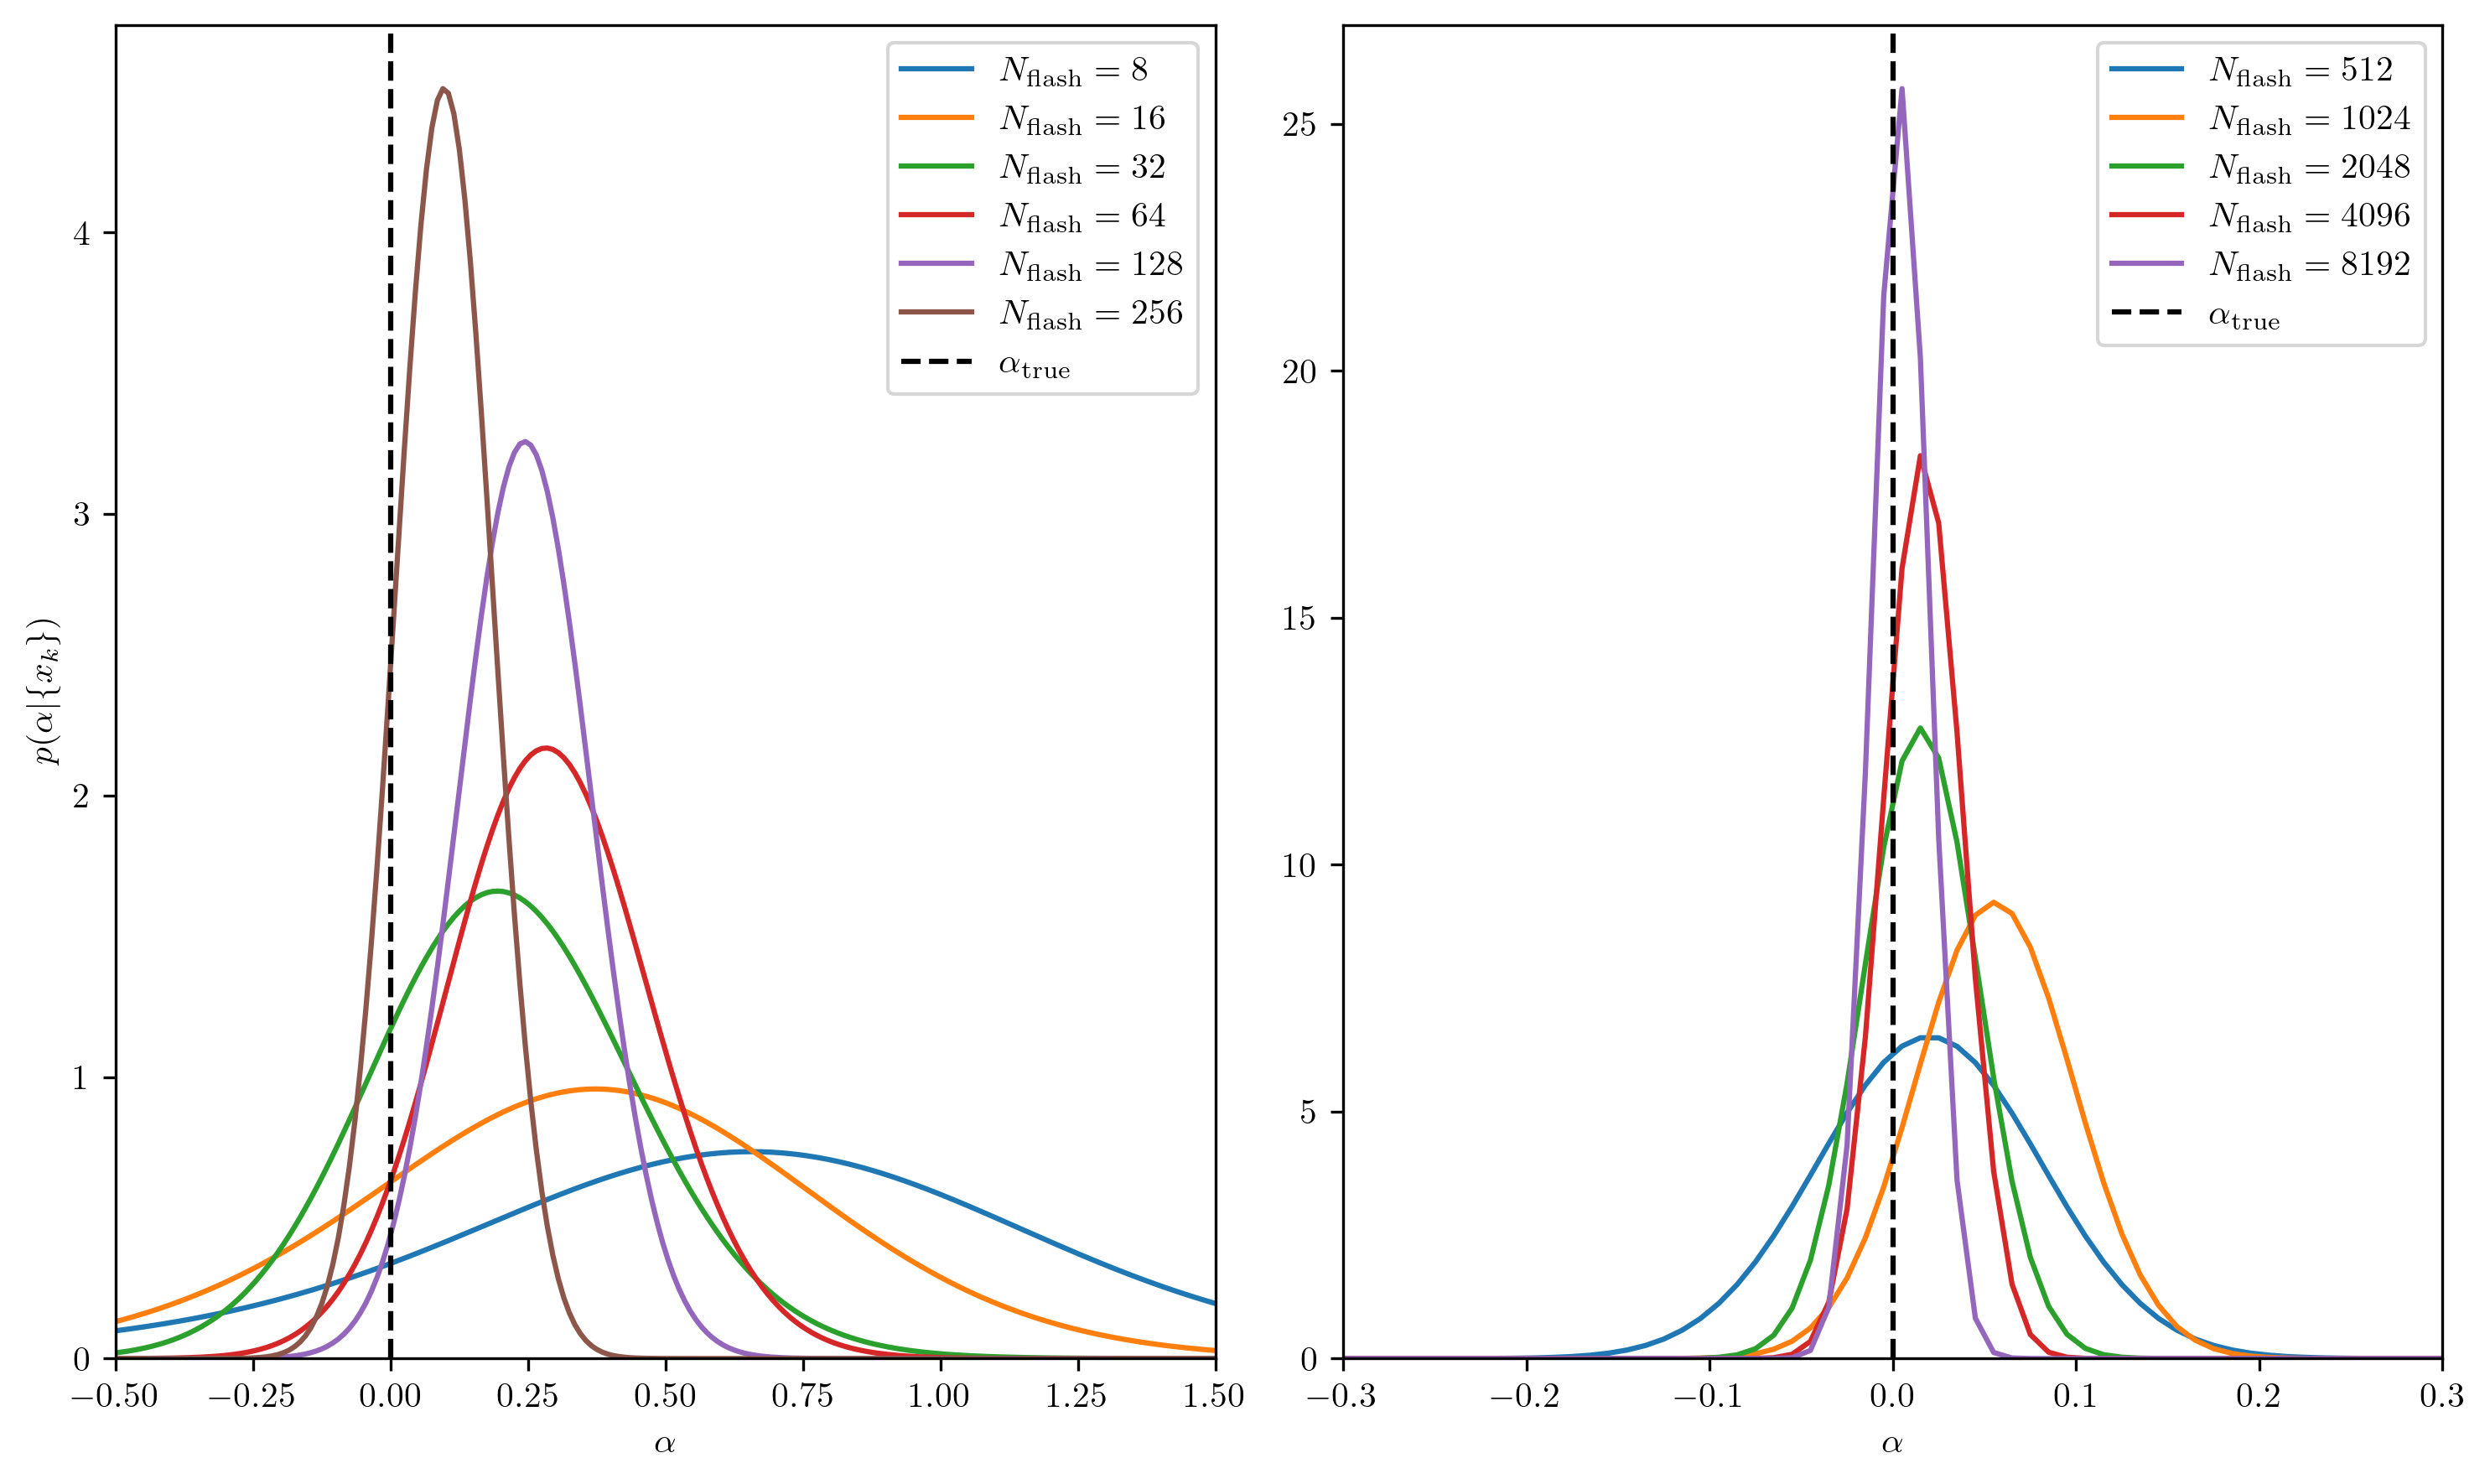

In [12]:
plt.figure(figsize = (10, 6))
ax = [plt.subplot2grid((1, 2), (0, i)) for i in range(2)]

# Plot the posterior distributions of alpha for different N_flash values
for i, n in enumerate(nflash):
    idx = i // ((len(nflash) + 1) // 2)
    ax[idx].plot(
        alpha_grid,
        posteriors[i],
        label = rf'$N_{{\rm flash}}={n}$'
    )

for a in ax:
    a.axvline(
        alpha_true,
        color = 'k',
        linestyle = '--',
        label = r'$\alpha_{\rm true}$'
    )
    a.legend()
    a.set_ylim(0, None)

# NOTE: EDIT BELOW to set axes scales and ranges
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
ax[0].set_xlim(-0.5, 1.5)
ax[1].set_xlim(-0.3, 0.3)
ax[0].set_ylabel(r'$p(\alpha | \{x_k\})$')
ax[0].set_xlabel(r'$\alpha$')
ax[1].set_xlabel(r'$\alpha$')

plt.tight_layout()

#### Question 1.3: Summary statistics of the posterior

**Tasks:**
1. For each posterior distribution in Question 1.2, compute the posterior mean $\mu_{\rm post}$ and standard deviation $\sigma_{\rm post}$.
2. Plot the posterior means and standard deviations as a function of $N_{\rm flash}$ using appropriate axes scales. Overlay the $\propto 1/\sqrt{N_{\rm flash}}$ trend.
3. Compute the median and half of the 16-84 percentile interval of the posterior distribution for each $N_{\rm flash}$, and plot them as a function of $N_{\rm flash}$. Overplot the means and standard deviations from Task 2 for comparison, and overlay the $\propto 1/\sqrt{N_{\rm flash}}$ trend.
4. Discuss your observations for all the plots in this exercise.

In [13]:
def posterior_summary_moment(alpha, posterior):
    """Compute the posterior mean and standard deviation
    Args:
        alpha : array, grid of alpha values
        posterior : array, posterior distribution of alpha
    Returns:
        mu_post : float, posterior mean
        sigma_post : float, posterior standard deviation
    """
    # NOTE: EDIT BELOW to compute the posterior mean and standard deviation
    pdf = np.asarray(posterior, dtype = float)
    pdf /= np.trapezoid(pdf, alpha)
    mu_post = np.mean(posterior)
    sigma_post = np.std(posterior)
    return mu_post, sigma_post

In [14]:
from scipy.integrate import cumulative_trapezoid

def compute_percentile(x, pdf, percentiles = [16, 50, 84]):
    """Compute the percentile of a distribution given its PDF
    Args:
        x : array, grid of x values
        pdf : array, probability density function values corresponding to x
        percent : float, desired percentile (0-100)
    Returns: array of percentile values
    """
    cdf = cumulative_trapezoid(pdf, x, initial = 0)
    cdf /= cdf[-1] # Normalize to make it a proper CDF
    return np.interp(np.array(percentiles) / 100, cdf, x)

def posterior_summary_percentile(alpha, posterior):
    pdf = np.asarray(posterior, dtype = float)
    pdf /= np.trapezoid(pdf, alpha)
    # NOTE: EDIT BELOW to compute the median and 16-84 percentiles
    # compute percentiles using the PDF and alpha grid
    p16, median, p84 = compute_percentile(
        alpha,
        pdf,
        percentiles = [16, 50, 84]
    )
    return median, p16, p84

In [15]:
alpha_post_mean = [] # Store posterior means
alpha_post_std = [] # Store posterior standard deviations
alpha_post_median = [] # Store posterior medians
alpha_post_half16_84 = [] # Store half of the 16-84 percentile intervals

# Compute summary statistics for each posterior distribution
for i, n in enumerate(nflash):
    mu_post, sigma_post = posterior_summary_moment(alpha_grid, posteriors[i])
    median, p16, p84 = posterior_summary_percentile(alpha_grid, posteriors[i])
    alpha_post_mean.append(mu_post)
    alpha_post_std.append(sigma_post)
    alpha_post_median.append(median)
    alpha_post_half16_84.append((p84 - p16) / 2)

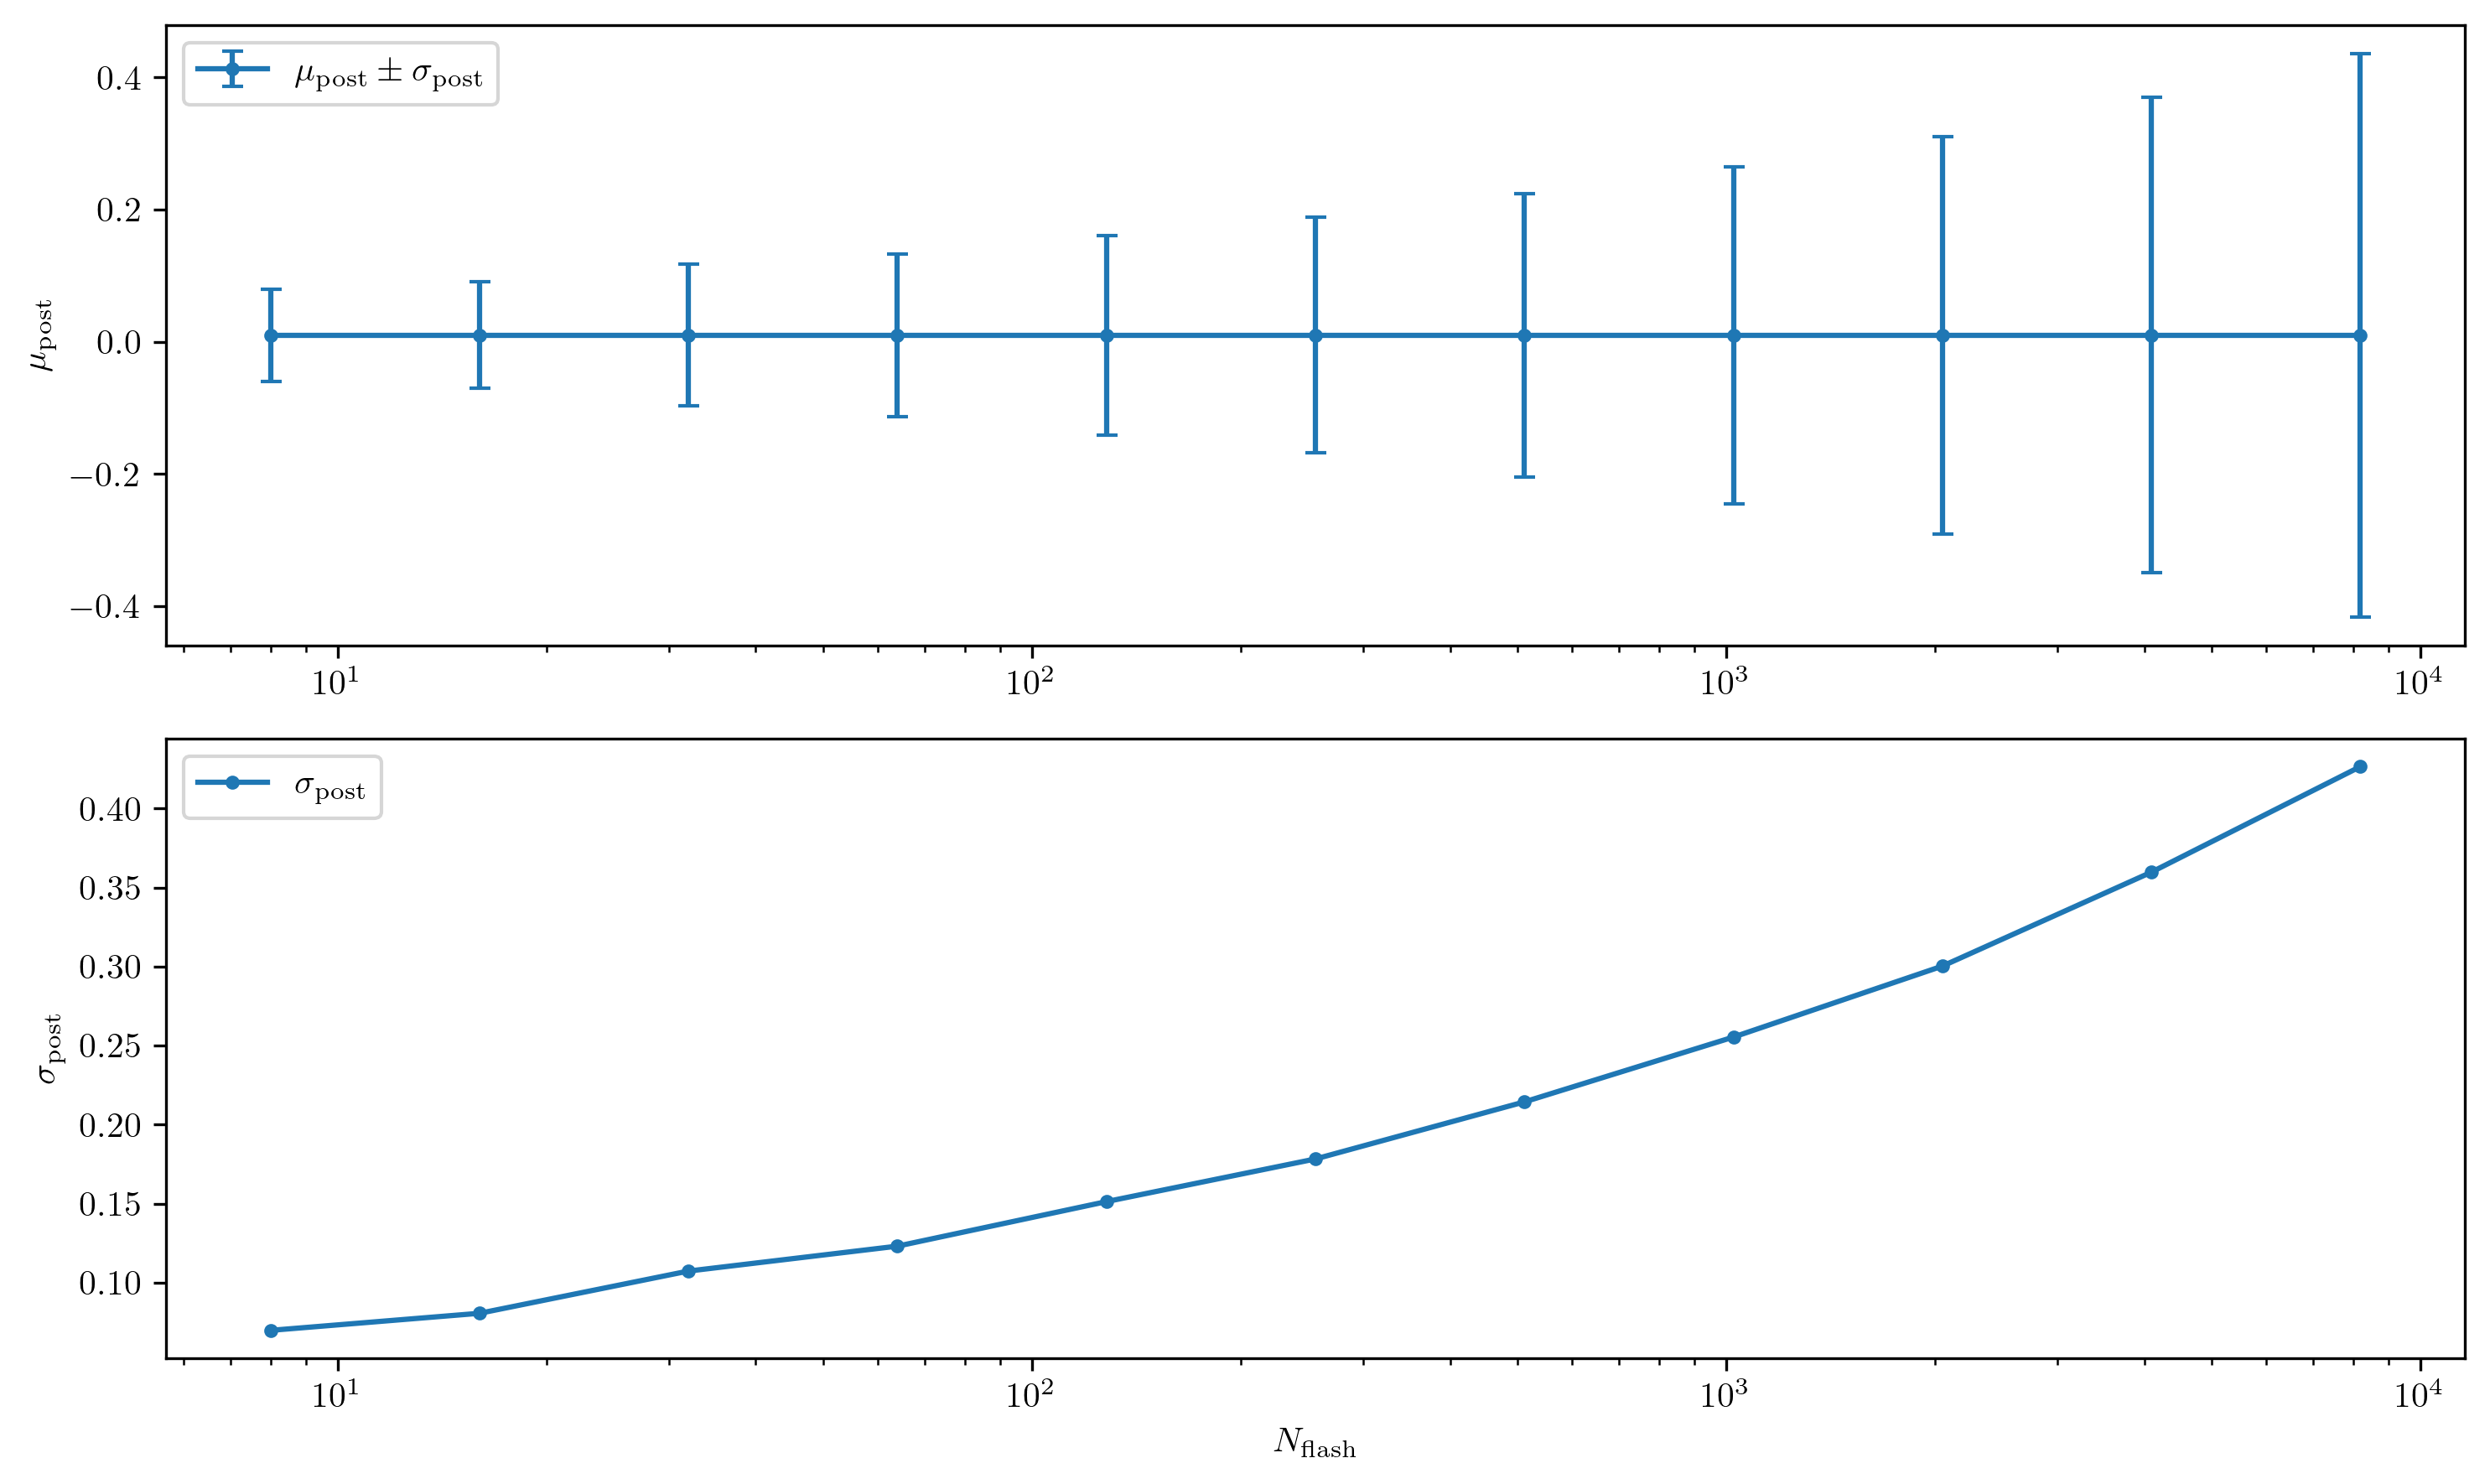

In [16]:
plt.figure(figsize = (10, 6))
ax = [plt.subplot2grid((2, 1), (i, 0)) for i in range(2)]
plt.subplots_adjust(hspace = 0)

# Plot the posterior means and standard deviations as a function of N_flash
ax[0].errorbar(
    nflash,
    alpha_post_mean,
    yerr = alpha_post_std,
    fmt = '.-',
    capsize = 3,
    label = r'$\mu_{\rm post} \pm \sigma_{\rm post}$'
)
ax[1].plot(
    nflash,
    alpha_post_std,
    '.-',
    label = r'$\sigma_{\rm post}$'
)

# NOTE: EDIT BELOW to overlay the 1/sqrt(N_flash) line and set axes scales and ranges
ax[0].set_xscale('log')
ax[1].set_xscale('log')

for a in ax:
    a.legend()

ax[0].set_ylabel(r'$\mu_{\rm post}$')
ax[1].set_ylabel(r'$\sigma_{\rm post}$')
ax[1].set_xlabel(r'$N_{\rm flash}$')
plt.tight_layout()

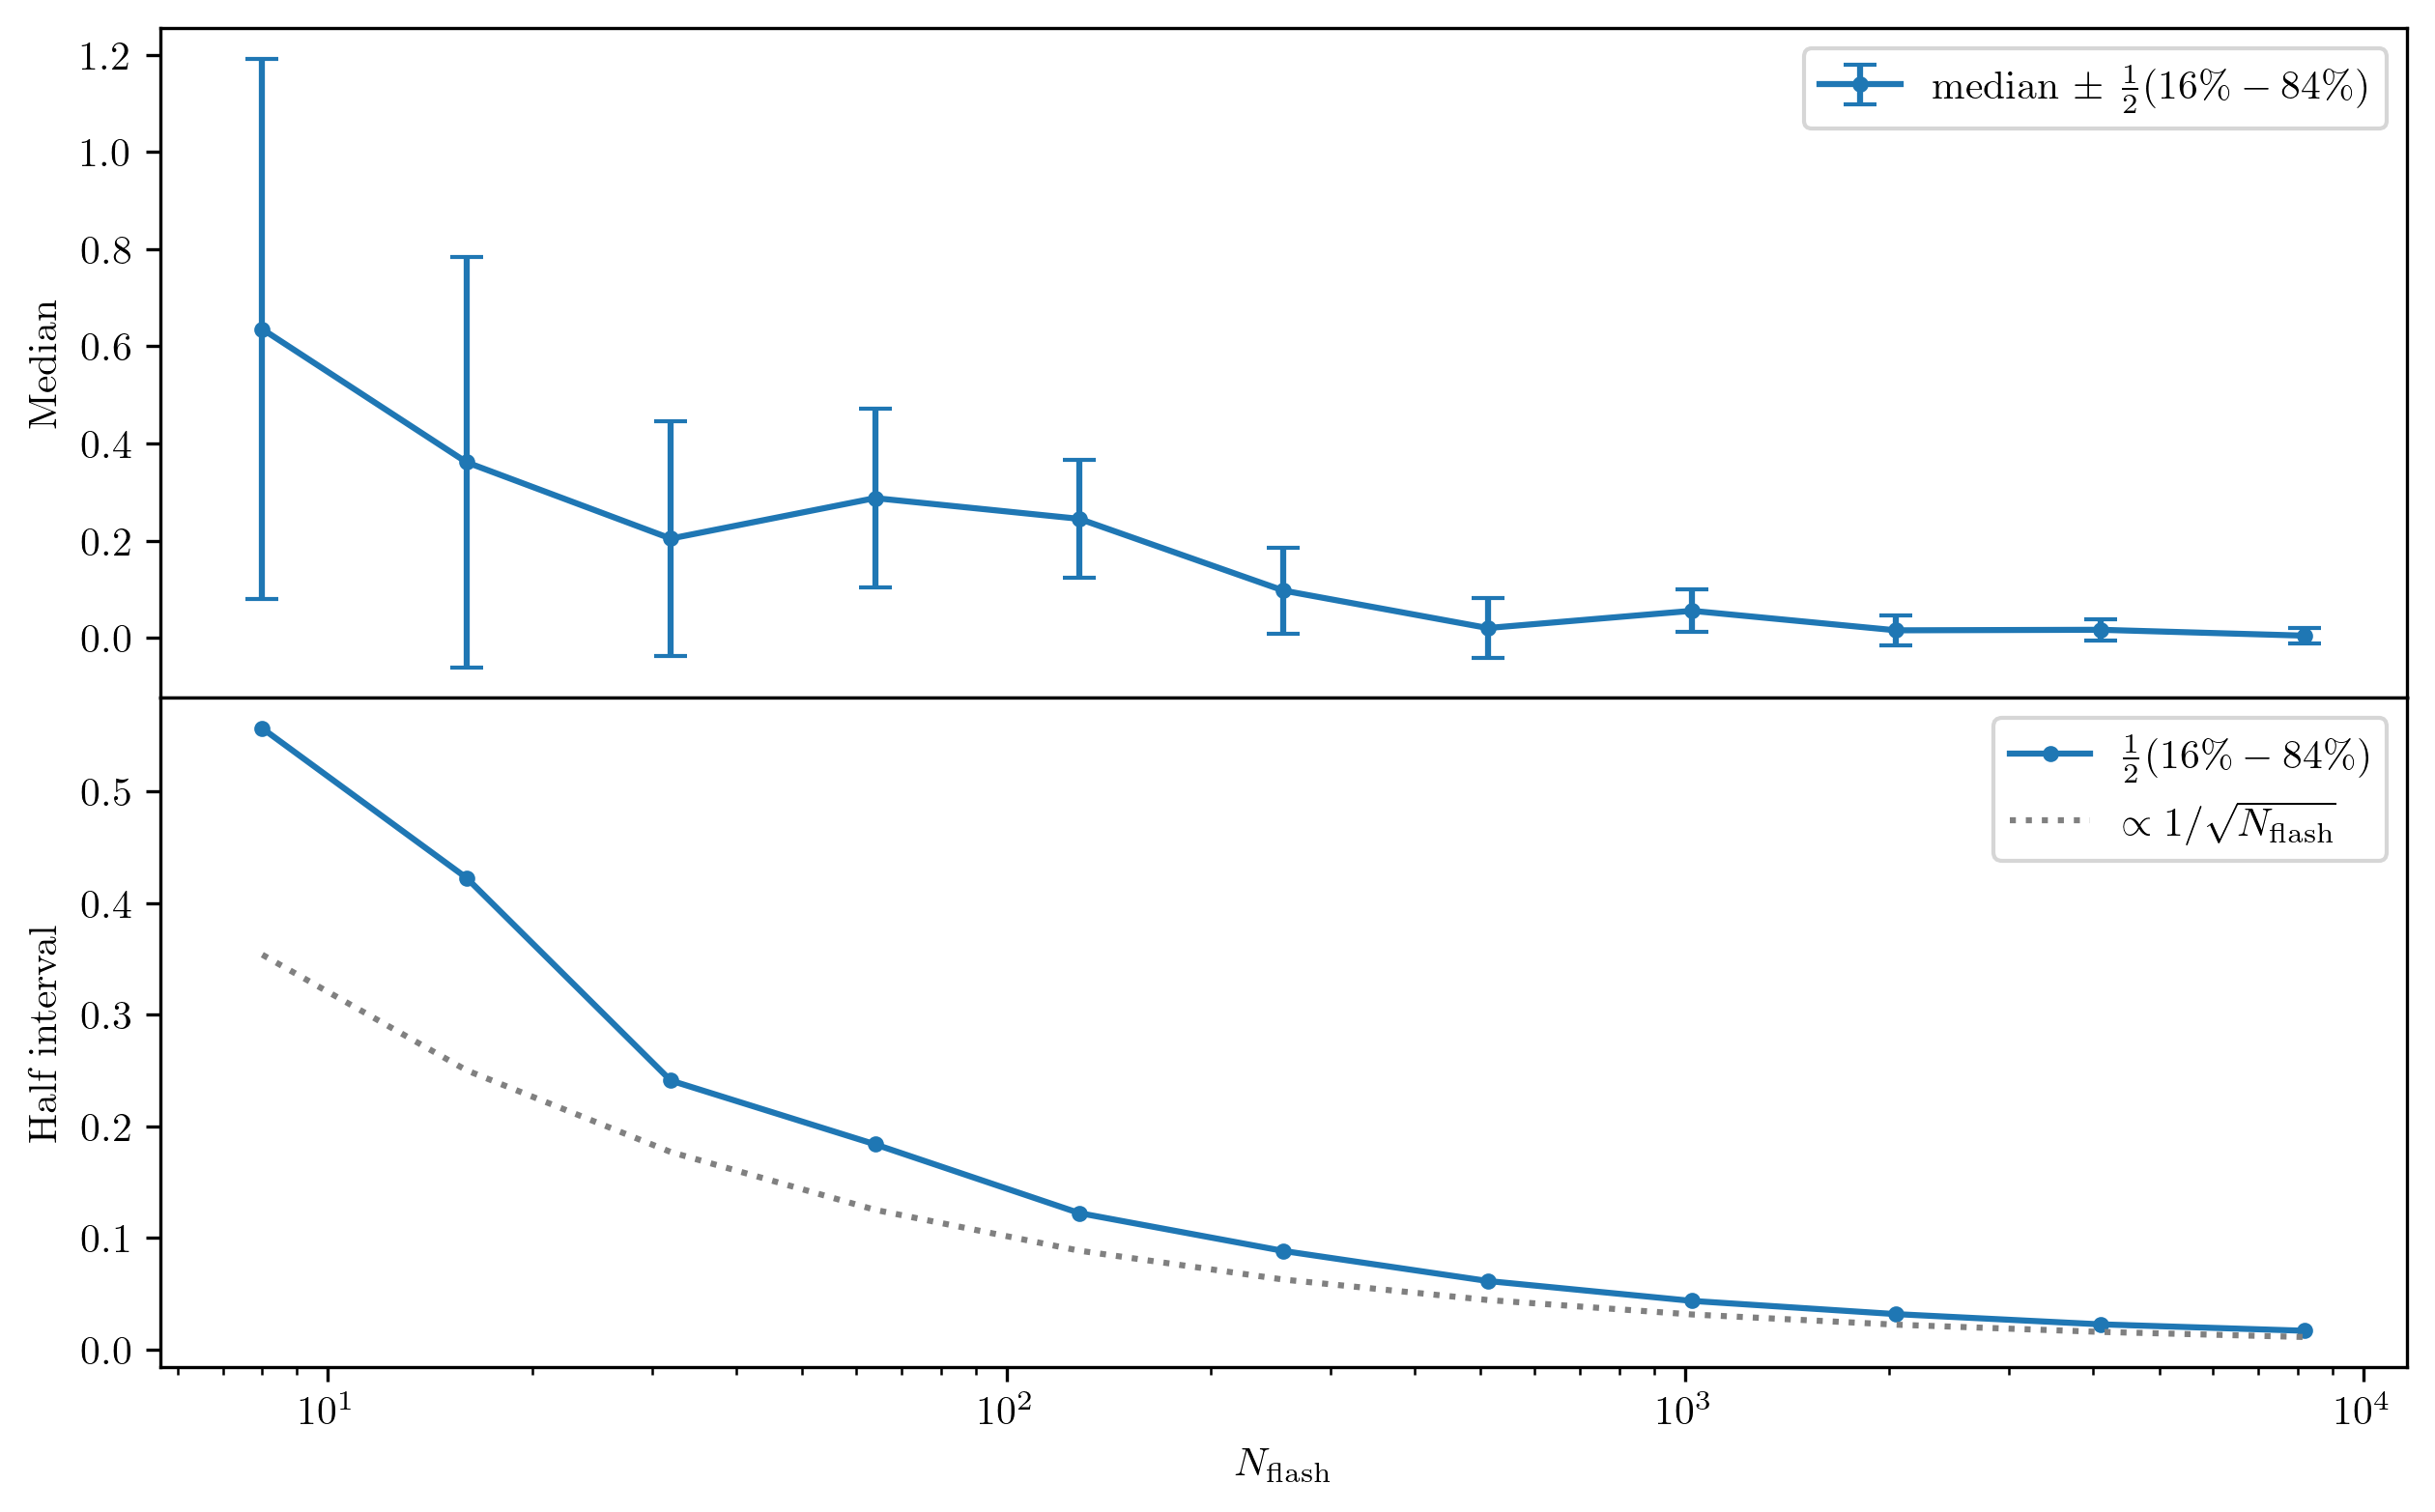

In [17]:
# NOTE: EDIT BELOW to compare the median and half of the 16-84 percentile 
plt.figure(figsize = (10, 6))
ax = [plt.subplot2grid((2, 1), (i, 0)) for i in range(2)]
plt.subplots_adjust(hspace = 0)

ax[0].errorbar(
    nflash,
    alpha_post_median,
    yerr = alpha_post_half16_84,
    fmt = '.-',
    capsize = 4,
    label = r'median $\pm$ $\frac{1}{2}(16\%-84\%)$'
)

ax[1].plot(
    nflash,
    alpha_post_half16_84,
    '.-',
    label = r'$\frac{1}{2}(16\%-84\%)$'
)

trend = 1 / np.sqrt(nflash)

ax[1].plot(
    nflash,
    trend,
    ':',
    color = 'gray',
    label = r'$\propto 1/\sqrt{N_{\rm flash}}$'
)
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].legend()
ax[1].legend()

ax[0].set_ylabel('Median')
ax[1].set_ylabel('Half interval')
ax[1].set_xlabel(r'$N_{\rm flash}$')

plt.show()

### Exercise 2: Source brightness

A steady source has a true flux $\phi = 5\,{\rm photon}\,{\rm s}^{-1}$. We observe photon counts $n$ in exposures of duration $t$. The counts are Poisson distributed with mean $\phi t$:

$$
n \sim \text{Poisson}(\phi t) = \frac{(\phi t)^{n} e^{-\phi t}}{n!}.
$$

#### Question 2.1: Flux inference with simulated data

**Tasks:**
1. For each exposure time $t \in \{0.5, 2, 10\}\,{\rm s}$, simulate $N=10$ independent observations of photon counts $n$ from the source.
2. For each exposure time, compute the posterior distribution of the flux $\phi$ with a flat prior in the range $[0.1, 20]$. Plot the posterior distributions and report the posterior means, standard deviations, and 16-50-84 percentiles.

**Hints:**
1. Compute the likelihood function on a grid of $\phi$ values based on the Poisson formula above.
2. It may be easier to work with the log-likelihood and log-posterior functions.

In [18]:
def sim_photon_counts(num, phi, exposure_time, seed = 42):
    """Simulate photon counts from a Poisson distribution
    Args:
        num : int, number of observations
        phi : float, true Poisson rate
        exposure_time : float, exposure time for each observation
        seed : int, random seed for reproducibility (default: 42)
    Returns: array of photon counts
    """
    rng = np.random.default_rng(seed)
    counts = rng.poisson(lam = phi * exposure_time, size = num)
    return counts

def posterior_flux(data, exposure_time, prior_range = (0.1, 20)):
    """Compute the posterior distribution of the Poisson rate phi given the data.
    Args:
        data : array, observed photon counts
        exposure_time : float, exposure time for each observation
        prior_range : tuple, (min, max) range for the flat prior (default: (0.1, 20))
    Returns:
        phi : array, grid of phi values
        posterior : array, posterior distribution of phi
    """
    phi = np.linspace(prior_range[0], prior_range[1], 1000)
    n_expected = phi * exposure_time
    # NOTE: EDIT BELOW to compute the Poisson likelihood; note that the factorial term can be ignored for the posterior calculation as we will normalize later
    loglike = np.sum(
        data[:, None] * np.log(n_expected[None, :]) - n_expected[None, :],
        axis = 0
    )

    posterior = np.exp(loglike - np.max(loglike)) # Subtract max for numerical stability
    return phi, posterior / posterior.sum() # Normalize posterior

In [38]:
# Simulate photon counts
num_samples = 10
phi_true = 5.0
exposure_times = [0.5, 2, 10] # Different exposure times

photon_data = [
    sim_photon_counts(num_samples, phi_true, t, seed = seed) for t in exposure_times
]

# Compute posterior distributions for different exposure times
posteriors_flat = []
for data, exp_time in zip(photon_data, exposure_times):
    phi_grid, posterior = posterior_flux(data, exp_time)
    posteriors_flat.append((phi_grid, posterior))

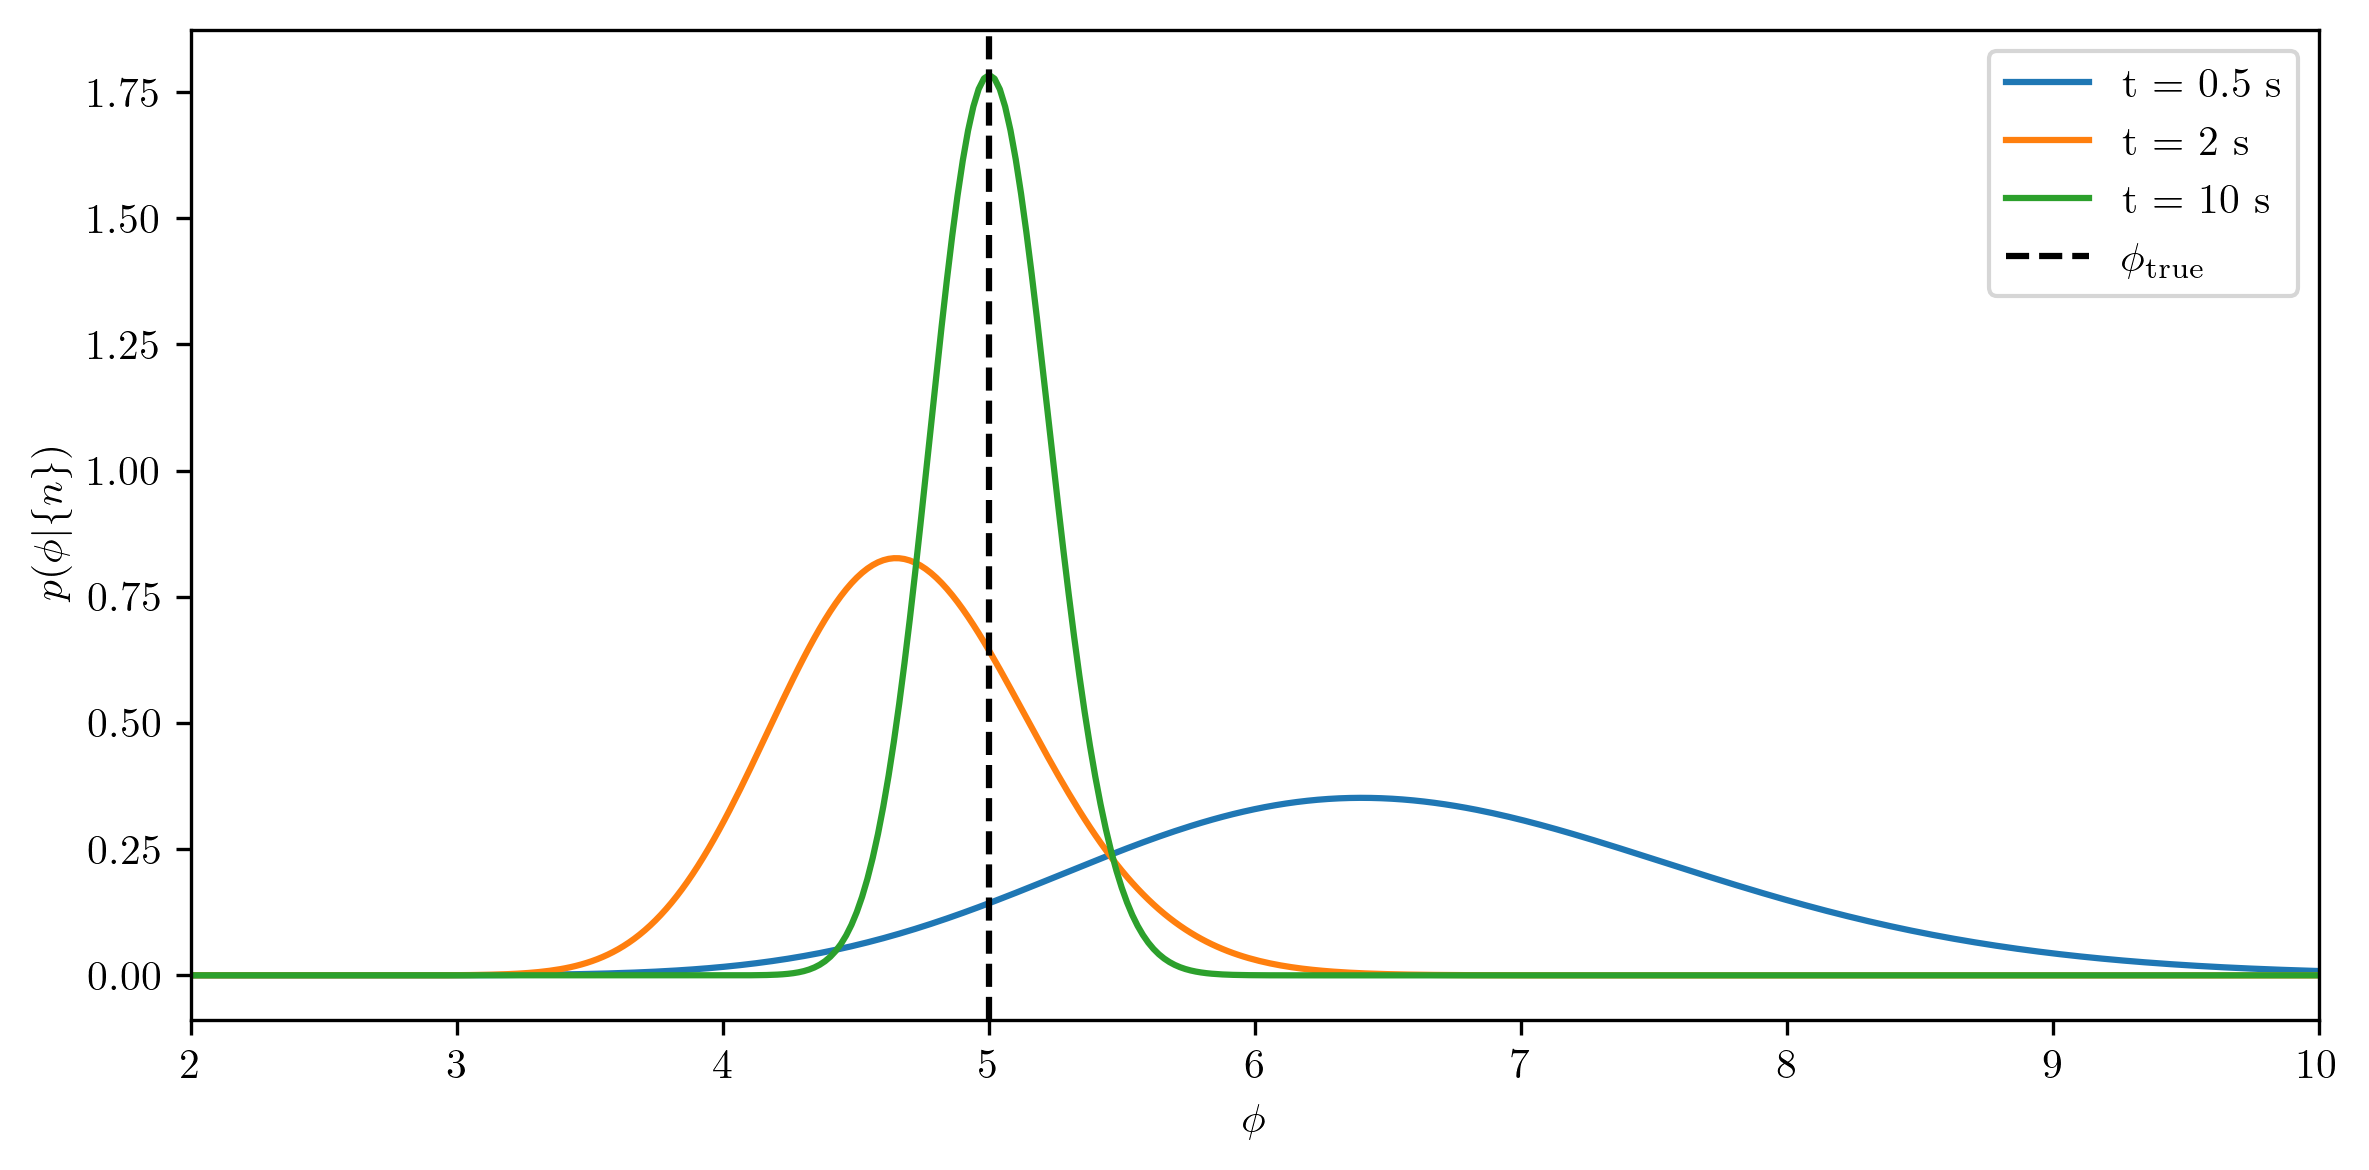

t =  0.5 s : mean = 6.600, std = 1.149, 16-50-84 = [5.462, 6.533, 7.736]
t =    2 s : mean = 4.700, std = 0.485, 16-50-84 = [4.218, 4.683, 5.181]
t =   10 s : mean = 5.010, std = 0.224, 16-50-84 = [4.787, 5.007, 5.233]


In [39]:
# NOTE: EDIT BELOW to plot the posterior distributions for different exposure times using the flat prior, and compute summary statistics
# Plot posterior distributions (flat prior) and compute summary statistics
phi_means = []
phi_stds = []
phi_p16 = []
phi_p50 = []
phi_p84 = []

plt.figure(figsize = (8, 4))
for (phi_grid, posterior), t in zip(posteriors_flat, exposure_times):
    pdf = np.asarray(posterior, dtype = float)
    pdf /= np.trapezoid(pdf, phi_grid) # ensure proper normalization on grid

    plt.plot(phi_grid, pdf, label = f't = {t} s')

    mu = np.trapezoid(phi_grid * pdf, phi_grid)
    var = np.trapezoid((phi_grid - mu)**2 * pdf, phi_grid)
    sigma = np.sqrt(var)

    p16, p50, p84 = compute_percentile(
        phi_grid,
        pdf,
        percentiles = [16, 50, 84]
    )

    phi_means.append(mu)
    phi_stds.append(sigma)
    phi_p16.append(p16)
    phi_p50.append(p50)
    phi_p84.append(p84)

plt.axvline(
    phi_true,
    color = 'k',
    linestyle = '--',
    label = r'$\phi_{\rm true}$'
)
plt.xlim(2, 10)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$p(\phi|\{n\})$')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
for t, mu, sigma, p16, p50, p84 in zip(
    exposure_times,phi_means, phi_stds, phi_p16, phi_p50, phi_p84
):
    print(
        f"t = {t:>4} s : mean = {mu:.3f}, std = {sigma:.3f}, 16-50-84 = [{p16:.3f}, {p50:.3f}, {p84:.3f}]"
    )

#### Question 2.2: Inference with Jeffreys' prior

The Jeffreys' prior for the Poisson rate $\phi$ is given by $p(\phi) \propto 1/\sqrt{\phi}$.

**Tasks:**
1. Repeat Question 2.1 using the Jeffreys' prior instead of the flat prior in the range $[0.1, 20]$.
2. Overplot the posterior distributions obtained with the flat prior and the Jeffreys' prior for each exposure time, and compare the summary statistics (means, standard deviations, percentiles).

In [40]:
def posterior_flux_jeffreys_prior(data, exposure_time, prior_range = (0.1, 20)):
    """Compute the posterior distribution of the Poisson rate phi given the data using Jeffreys' prior.
    Args:
        data : array, observed photon counts
        exposure_time : float, exposure time for each observation
        prior_range : tuple, (min, max) range for the Jeffreys' prior (default: (0.1, 20))
    Returns:
        phi : array, grid of phi values
        posterior : array, posterior distribution of phi
    """
    phi = np.linspace(prior_range[0], prior_range[1], 1000)
    n_expected = phi * exposure_time
    # NOTE: EDIT BELOW to compute the Poisson likelihood; note that the factorial term can be ignored for the posterior calculation as we will normalize later
    loglike = np.sum(
        data[:, None] * np.log(n_expected[None, :]) - n_expected[None, :],
        axis = 0
    )

    # Jeffreys' prior: p(phi) propto 1/sqrt(phi)
    logprior = -0.5 * np.log(phi)

    logpost = loglike + logprior
    posterior = np.exp(logpost - np.max(logpost)) # Subtract max for numerical stability
    return phi, posterior / posterior.sum() # Normalize posterior

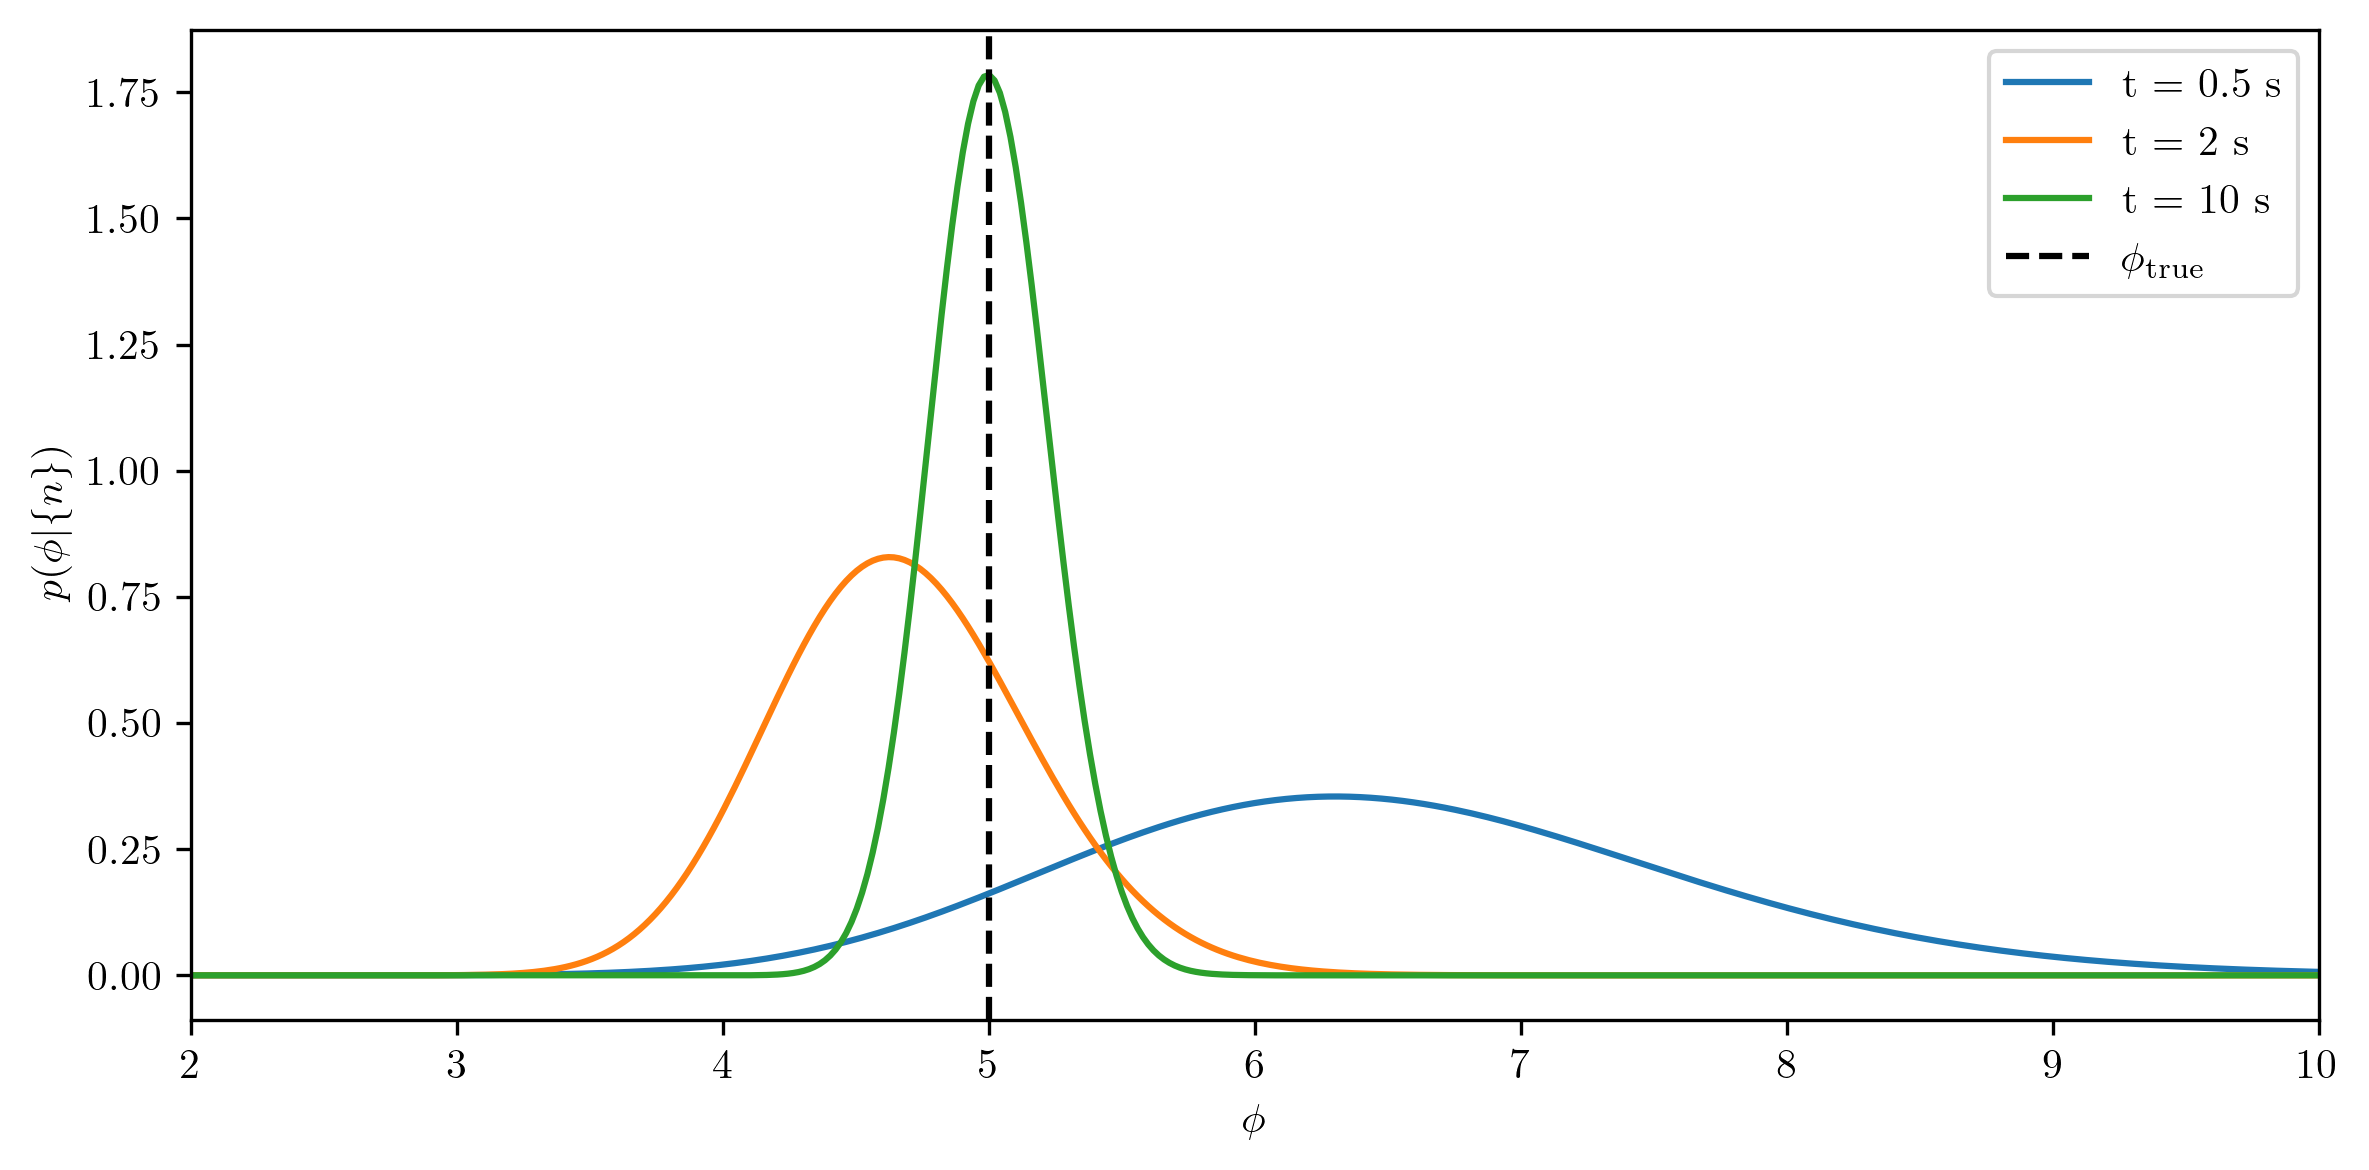

t =  0.5 s : mean = 6.500, std = 1.140, 16-50-84 = [5.371, 6.433, 7.627]
t =    2 s : mean = 4.675, std = 0.483, 16-50-84 = [4.195, 4.658, 5.155]
t =   10 s : mean = 5.005, std = 0.224, 16-50-84 = [4.782, 5.002, 5.228]


In [41]:
# NOTE: EDIT BELOW to plot the posterior distributions and compute summary statistics
posteriors = []
for data, exp_time in zip(photon_data, exposure_times):
    phi_grid, posterior = posterior_flux_jeffreys_prior(data, exp_time)
    posteriors.append((phi_grid, posterior))
# Plot posterior distributions (Jeffreys' prior) and compute summary statistics
phi_means = []
phi_stds = []
phi_p16 = []
phi_p50 = []
phi_p84 = []

plt.figure(figsize = (8, 4))
for (phi_grid, posterior), t in zip(posteriors, exposure_times):
    pdf = np.asarray(posterior, dtype = float)
    pdf /= np.trapezoid(pdf, phi_grid)

    plt.plot(phi_grid, pdf, label = f't = {t} s')

    mu = np.trapezoid(phi_grid * pdf, phi_grid)
    var = np.trapezoid((phi_grid - mu)**2 * pdf, phi_grid)
    sigma = np.sqrt(var)

    p16, p50, p84 = compute_percentile(
        phi_grid,
        pdf,
        percentiles = [16, 50, 84]
    )

    phi_means.append(mu)
    phi_stds.append(sigma)
    phi_p16.append(p16)
    phi_p50.append(p50)
    phi_p84.append(p84)

plt.axvline(
    phi_true,
    color = 'k',
    linestyle = '--',
    label = r'$\phi_{\rm true}$'
)
plt.xlim(2, 10)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$p(\phi|\{n\})$')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
for t, mu, sigma, p16, p50, p84 in zip(
    exposure_times, phi_means, phi_stds, phi_p16, phi_p50, phi_p84
):
    print(
        f"t = {t:>4} s : mean = {mu:.3f}, std = {sigma:.3f}, 16-50-84 = [{p16:.3f}, {p50:.3f}, {p84:.3f}]"
    )

#### Question 2.3: Inference with Gaussian likelihood

In reality the photon counts may not be from a single source, but from foreground contamination or background noise. In this case, a practical approach is to estimate the error on the counts using the observed counts $n_i$ as an approximation of the true mean $\phi t$. This leads to a Gaussian likelihood for $\phi$:

$$ p(n_i | \phi) \propto \exp\left(-\frac{(n_i - \phi t)^2}{2 \sigma_i^2}\right) $$

where $\sigma_i = \sqrt{n_i}$.

**Tasks:**
1. Compute the posterior distribution for $\phi$ using the Gaussian likelihood. Set $\sigma_i^2 = \max(n_i, 1)$ to avoid division by zero when $n_i = 0$.
2. Try both the flat prior and the Jeffreys' prior, and compare the results with those from Questions 2.1 and 2.2.
3. Discuss your observations for all the questions in this exercise.

In [49]:
def posterior_flux_gauss_like(data, exposure_time, prior_type = 'flat', prior_range = (0.1, 20), gauss_prior_params = None, n_phi = 1000):
    """Gaussian-likelihood posterior for phi.
    Args:
        data : array-like, observed photon counts n_i
        exposure_time : float, exposure time t (same for all observations)
        prior_type : 'flat' | 'jeffreys' | 'gaussian'
        prior_range : (min, max) for phi grid
        gauss_prior_params : dict {'mu','sigma'} for optional gaussian prior on phi
        n_phi : int, number of grid points for phi
    Returns:
        phi : array, phi grid
        posterior : array, normalized posterior on grid
    Notes:
        Uses sigma_i^2 = max(n_i, 1) to avoid zero-variance.
    """
    phi = np.linspace(prior_range[0], prior_range[1], n_phi)
    mu = phi * exposure_time  # shape (M,)
    n = np.asarray(data)
    # avoid zero counts causing sigma=0
    sigma2 = np.maximum(n, 1.0)  # shape (N,)
    # squared residuals: shape (N, M)
    resid2 = (n[:, None] - mu[None, :])**2
    # Gaussian log-likelihood (include normalization term for correctness)
    # log L = -0.5 * sum_i [ resid2 / sigma2 + log(2π sigma2) ]
    loglike = -0.5 * np.sum(resid2 / sigma2[:, None] + np.log(2.0 * np.pi * sigma2)[:, None], axis=0)

    # priors
    if prior_type == 'flat':
        logprior = 0.0
    elif prior_type == 'jeffreys':
        # Jeffreys prior for Poisson rate phi ~ 1/sqrt(phi)
        # Guard against phi <= 0 (grid starts at >0)
        logprior = -0.5 * np.log(phi)
    elif prior_type == 'gaussian':
        if gauss_prior_params is not None:
            mu0 = float(gauss_prior_params.get('mu', 0.5 * (prior_range[0] + prior_range[1])))
            sigma0 = float(gauss_prior_params.get('sigma', 0.25 * (prior_range[1] - prior_range[0])))
        else:
            mu0 = 0.5 * (prior_range[0] + prior_range[1])
            sigma0 = 0.25 * (prior_range[1] - prior_range[0])
        logprior = -0.5 * ((phi - mu0) / sigma0)**2 - np.log(sigma0 * np.sqrt(2.0 * np.pi))
    else:
        raise ValueError("Invalid prior_type. Choose 'flat', 'jeffreys' or 'gaussian'.")

    logpost = loglike + logprior
    logpost -= np.max(logpost)  # stability
    posterior = np.exp(logpost)
    posterior /= np.trapezoid(posterior, phi)
    return phi, posterior

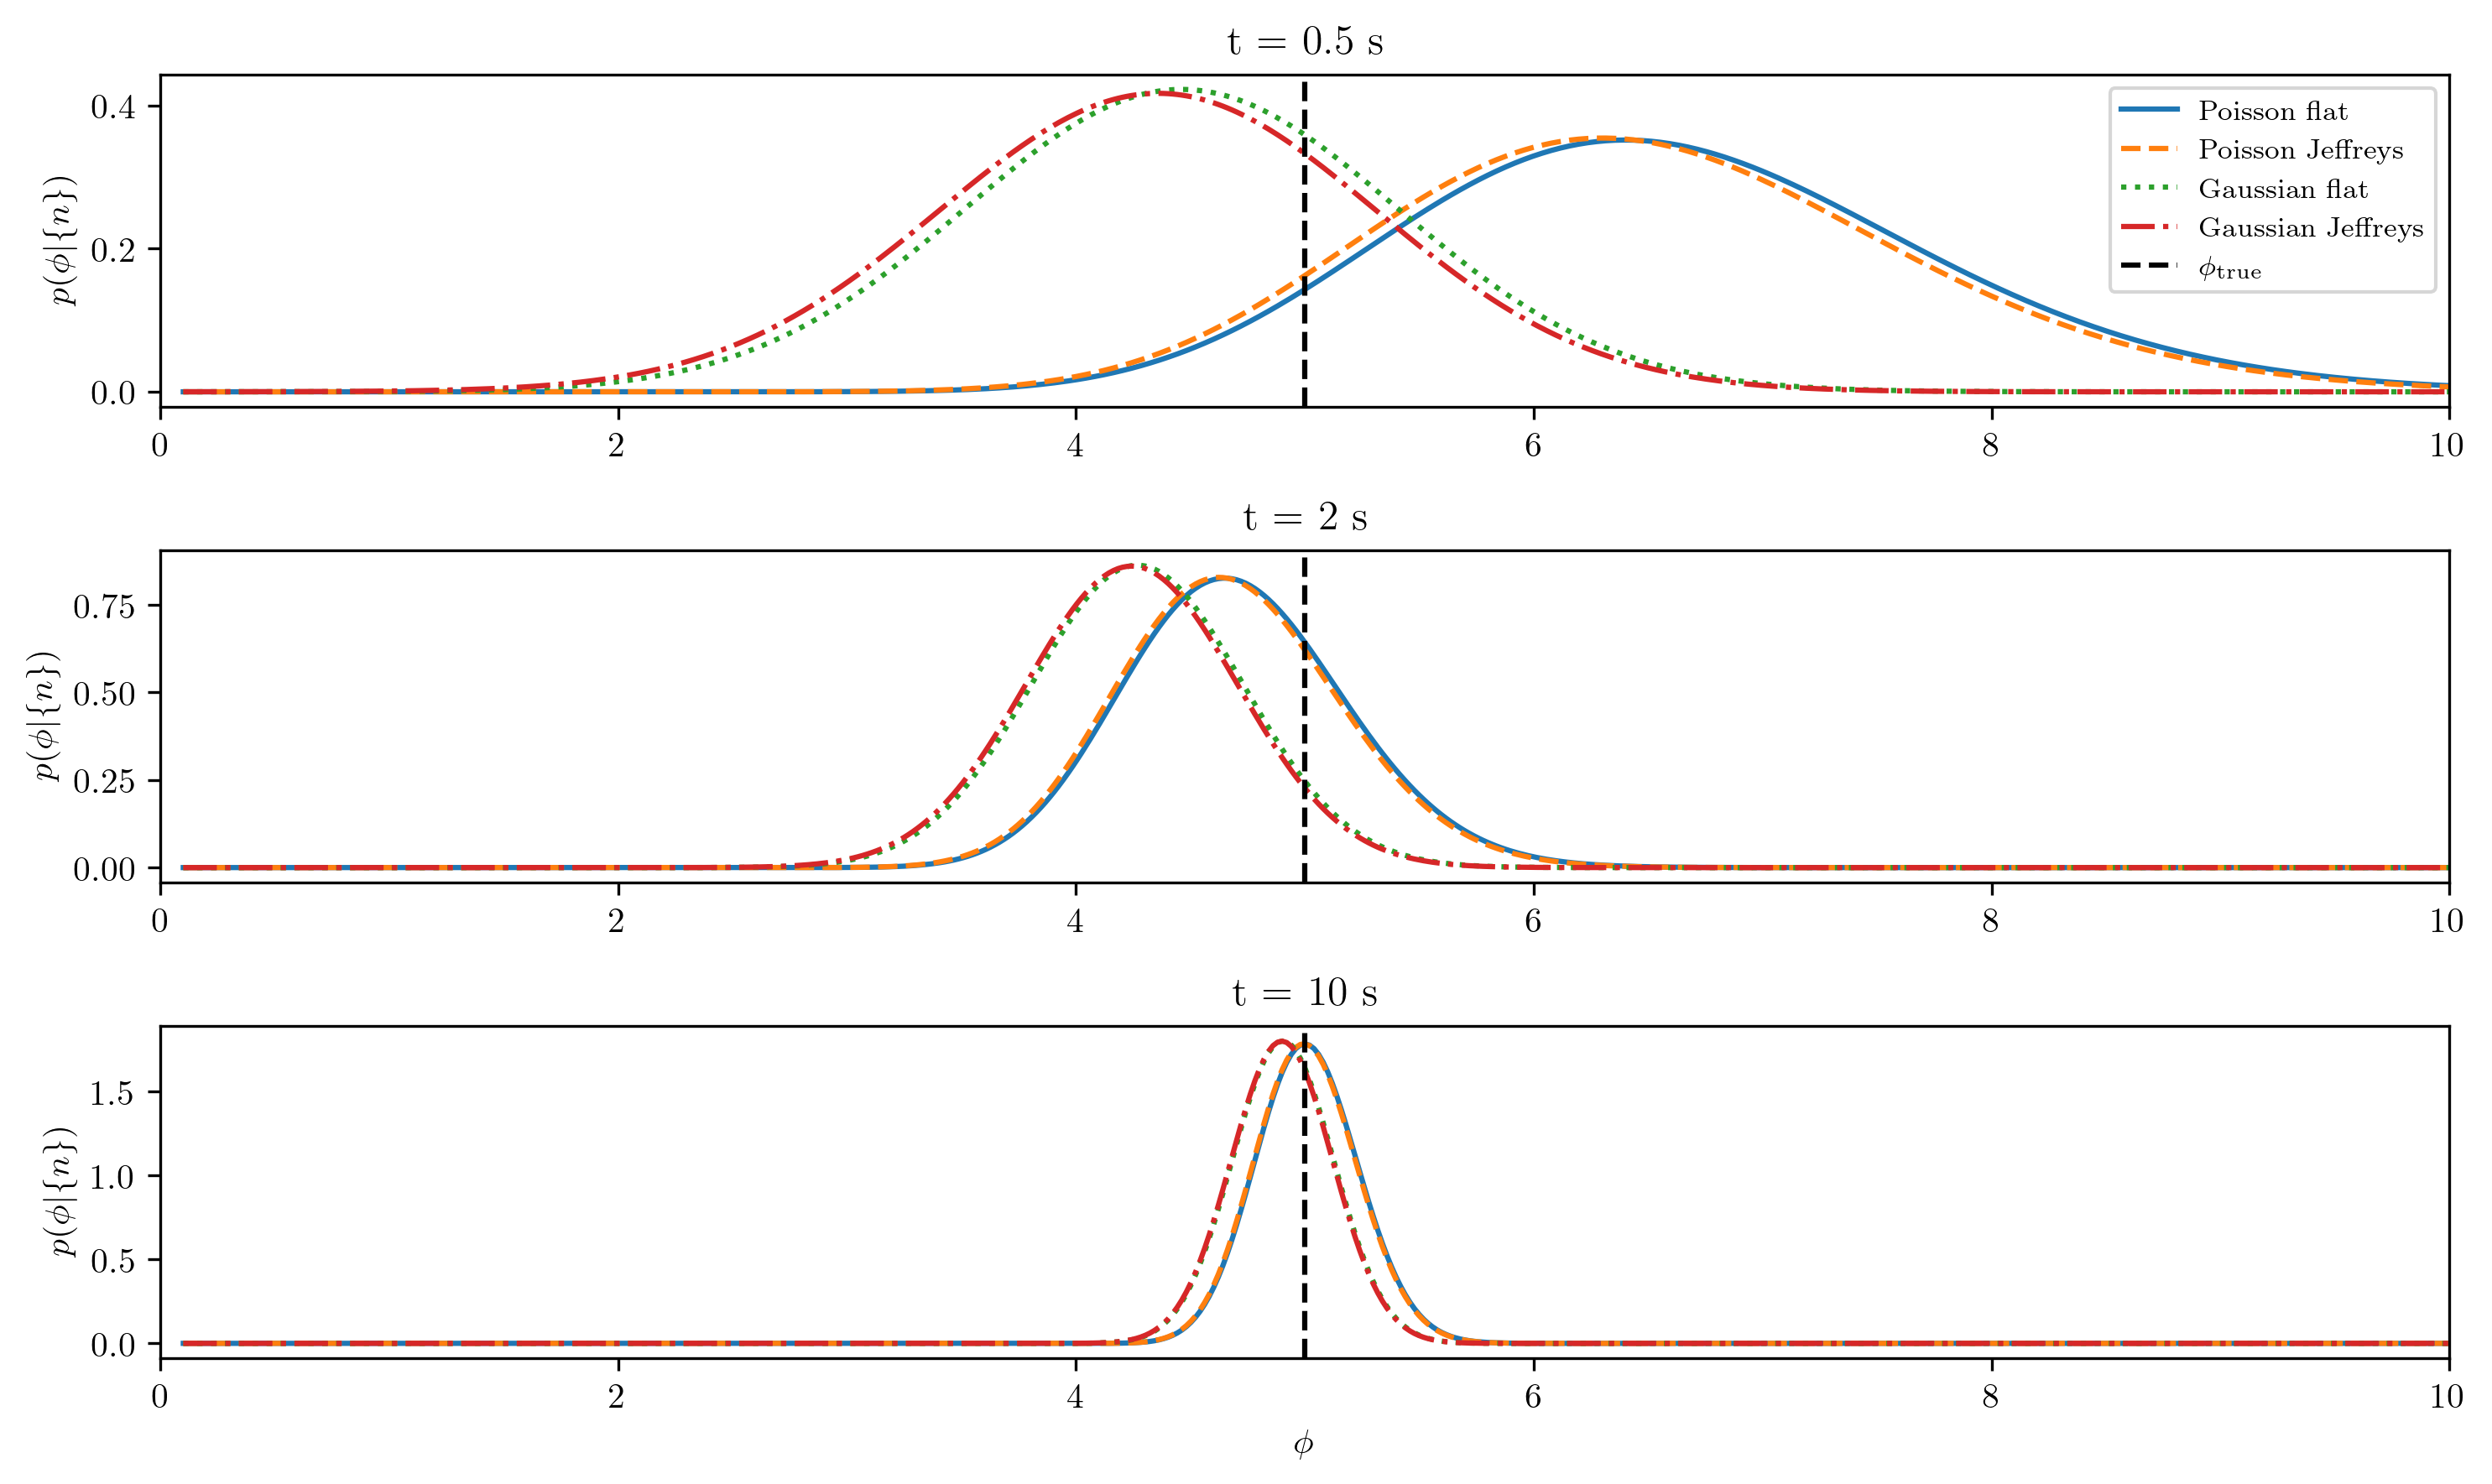

t =  0.5 s : Poisson-flat mean=6.600 std=1.149  |  Gauss-flat mean=4.461 std=0.945
t =    2 s : Poisson-flat mean=4.700 std=0.485  |  Gauss-flat mean=4.268 std=0.462
t =   10 s : Poisson-flat mean=5.010 std=0.224  |  Gauss-flat mean=4.904 std=0.221


In [54]:
# NOTE: EDIT BELOW to plot the posterior distributions and compute summary statistics
# Helper: compare Gaussian vs Poisson posteriors (flat & Jeffreys) and print stats
def compare_posteriors_gauss_vs_poisson(photon_data, exposure_times, phi_true = 5.0, prior_range = (0.1, 20)):
    """Compute and plot posteriors for each exposure time:
       - Poisson flat (posterior_flux)
       - Poisson Jeffreys (posterior_flux_jeffreys_prior)
       - Gaussian flat (posterior_flux_gauss_like)
       - Gaussian Jeffreys (posterior_flux_gauss_like with prior_type='jeffreys')
    Assumes posterior_flux and posterior_flux_jeffreys_prior exist in namespace.
    """
    plt.figure(figsize = (10, 6))
    for i, (data, t) in enumerate(zip(photon_data, exposure_times)):
        # Poisson flat
        phi_p_flat, post_p_flat = posterior_flux(data, t, prior_range=prior_range)
        phi_p_flat = np.asarray(phi_p_flat)
        pdf_p_flat = np.asarray(post_p_flat, dtype=float)
        pdf_p_flat /= np.trapezoid(pdf_p_flat, phi_p_flat)

        # Poisson Jeffreys
        phi_p_j, post_p_j = posterior_flux_jeffreys_prior(data, t, prior_range=prior_range)
        phi_p_j = np.asarray(phi_p_j)
        pdf_p_j = np.asarray(post_p_j, dtype=float)
        pdf_p_j /= np.trapezoid(pdf_p_j, phi_p_j)

        # Gaussian flat
        phi_g_flat, post_g_flat = posterior_flux_gauss_like(data, t, prior_type='flat', prior_range=prior_range)
        pdf_g_flat = np.asarray(post_g_flat, dtype=float)
        pdf_g_flat /= np.trapezoid(pdf_g_flat, phi_g_flat)

        # Gaussian Jeffreys
        phi_g_j, post_g_j = posterior_flux_gauss_like(data, t, prior_type='jeffreys', prior_range=prior_range)
        pdf_g_j = np.asarray(post_g_j, dtype=float)
        pdf_g_j /= np.trapezoid(pdf_g_j, phi_g_j)

        ax = plt.subplot(len(exposure_times), 1, i+1)
        ax.plot(phi_p_flat, pdf_p_flat, label='Poisson flat', color='C0')
        ax.plot(phi_p_j, pdf_p_j, label='Poisson Jeffreys', color='C1', linestyle='--')
        ax.plot(phi_g_flat, pdf_g_flat, label='Gaussian flat', color='C2', linestyle=':')
        ax.plot(phi_g_j, pdf_g_j, label='Gaussian Jeffreys', color='C3', linestyle='-.')
        ax.axvline(phi_true, color='k', ls='--', label=r'$\phi_{\rm true}$' if i==0 else None)
        ax.set_xlim(0, 10)
        ax.set_ylabel(r'$p(\phi|\{n\})$')
        if i == len(exposure_times) - 1:
            ax.set_xlabel(r'$\phi$')
        if i == 0:
            ax.legend(fontsize=8)
        ax.set_title(f't = {t} s')

    plt.xlim(0, 10)
    plt.tight_layout()
    plt.show()

    # Print summaries (example: Gaussian vs Poisson flat means)
    for data, t in zip(photon_data, exposure_times):
        phi_pf, pdf_pf = posterior_flux(data, t, prior_range=prior_range)
        phi_gf, pdf_gf = posterior_flux_gauss_like(data, t, prior_type='flat', prior_range=prior_range)
        pdf_pf = np.asarray(pdf_pf, dtype=float); pdf_pf /= np.trapezoid(pdf_pf, phi_pf)
        pdf_gf = np.asarray(pdf_gf, dtype=float); pdf_gf /= np.trapezoid(pdf_gf, phi_gf)
        mu_pf = np.trapezoid(phi_pf * pdf_pf, phi_pf); sigma_pf = np.sqrt(np.trapezoid((phi_pf - mu_pf)**2 * pdf_pf, phi_pf))
        mu_gf = np.trapezoid(phi_gf * pdf_gf, phi_gf); sigma_gf = np.sqrt(np.trapezoid((phi_gf - mu_gf)**2 * pdf_gf, phi_gf))
        print(f"t = {t:>4} s : Poisson-flat mean={mu_pf:.3f} std={sigma_pf:.3f}  |  Gauss-flat mean={mu_gf:.3f} std={sigma_gf:.3f}")
        
compare_posteriors_gauss_vs_poisson(photon_data, exposure_times, phi_true = 5.0, prior_range = (0.1, 20))

##### Discussions

数据量在很大的时候直接主导了整个后验的分布；在数据量不算很大的时候，先验有一定的作用.

### Exercise 3: Inference of amplitude from intensity

Suppose we are interested in the amplitude $A$ of a signal, but we can only measure its intensity $I = A^2$. The measurement uncertainty on $I$ is Gaussian with standard deviation $\sigma_I$.

#### Question 3.1: Posterior distribution of amplitude

**Tasks:**
1. Simulate $N=10$ measurements of $I$ with true amplitude $A_{\rm true} = 1$ and $\sigma_I = 1.5$. Note that it does not matter if some $I$ values are negative due to noise; real measurements can be negative after calibration.
2. Using the Jeffreys' prior $p(A) \propto |A|$ in the range $[-3, 3]$, compute the posterior distribution of $A$ based on the measurements of $I$. Assume $\sigma_I$ is known.
3. Plot the posterior distribution of $A$, and compute the posterior mean, standard deviation, and 16-50-84 percentiles.

In [55]:
def sim_intensity(num, A, sigma=1.5, seed=42):
    """Simulate intensity measurements given amplitude A with Gaussian noise.
    Args:
        num : int, number of measurements
        A : float, true amplitude
        sigma : float, standard deviation of Gaussian noise (default: 1.5)
        seed : int, random seed for reproducibility (default: 42)
    Returns: array of intensity measurements
    """
    rng = np.random.default_rng(seed)
    I_true = A**2
    I_measured = rng.normal(loc=I_true, scale=sigma, size=num)
    return I_measured

In [59]:
# NOTE: EDIT BELOW to implement the function for computing the posterior distribution of A given intensity measurements
def posterior_amplitude_given_intensity(I_data, sigma_I, prior_type='jeffreys', prior_range=(-3, 3), nA=2000):
    """Compute posterior p(A | {I_i}) given intensity measurements with Gaussian noise.
    Likelihood: I_i sim N(A^2, sigma_I^2)
    Priors supported:
      - 'jeffreys' : p(A) propto |A|  (on prior_range)
      - 'flat'      : constant on prior_range
    Args:
        I_data : array-like, measured intensities I_i
        sigma_I : float or array-like, measurement std (if scalar, applied to all)
        prior_type : 'jeffreys' or 'flat'
        prior_range : (min, max) range for A grid
        nA : int, number of grid points for A
    Returns:
        A : array, grid of A values
        posterior : array, normalized posterior p(A|data) on the grid
    """
    I = np.asarray(I_data)
    A = np.linspace(prior_range[0], prior_range[1], nA)
    # model predictions A^2 for each grid point
    A2 = A[None, :]**2  # shape (N_data, nA)

    # handle sigma_I
    sigma = np.asarray(sigma_I)
    if sigma.ndim == 0:
        sigma2 = np.full(I.shape, sigma**2)
    else:
        sigma2 = np.asarray(sigma)**2

    # Gaussian log-likelihood (up to additive constant)
    resid2 = (I[:, None] - A2)**2
    loglike = -0.5 * np.sum(resid2 / sigma2[:, None], axis=0)

    # prior
    if prior_type == 'jeffreys':
        # p(A) propto |A|  --> logprior = log(|A|)
        # add tiny epsilon to avoid log(0)
        eps = 1e-12
        logprior = np.log(np.abs(A) + eps)
    elif prior_type == 'flat':
        logprior = 0.0
    else:
        raise ValueError("prior_type must be 'jeffreys' or 'flat'")

    logpost = loglike + logprior
    logpost -= np.max(logpost)  # numerical stability
    post = np.exp(logpost)
    post /= np.trapezoid(post, A)    # normalize on grid

    return A, post

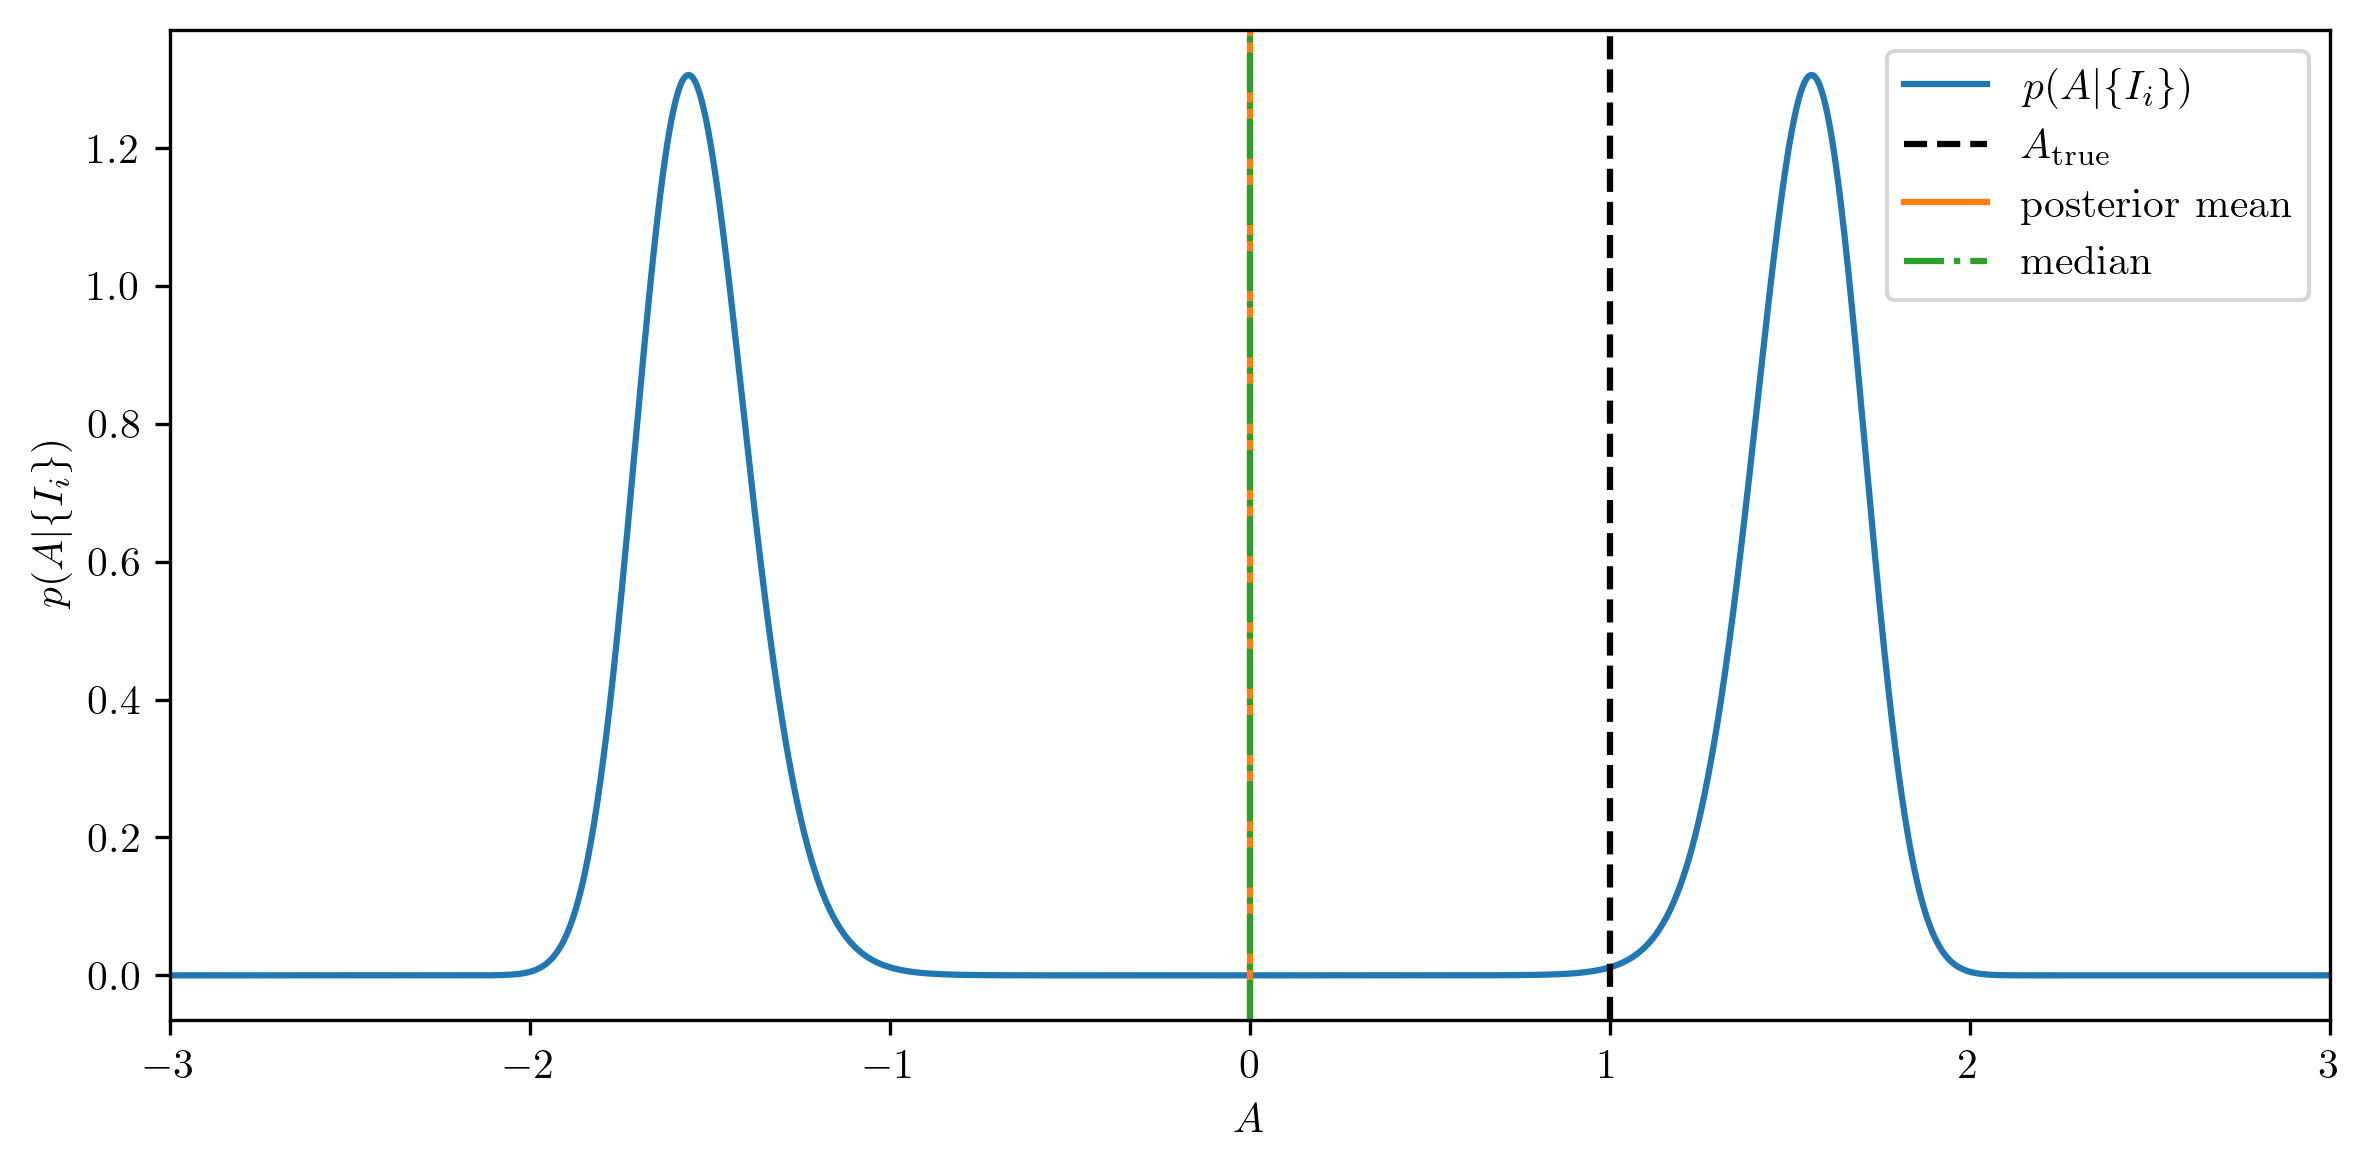

Posterior mean = -0.0000
Posterior std  = 1.5454
Percentiles 16/50/84 = [-1.6156, -0.0000, 1.6156]


In [61]:
# Simulate intensity measurements
num_samples = 10
A_true = 1.0
sigma_I = 1.5
intensity_data = sim_intensity(num_samples, A_true, sigma=sigma_I, seed=seed)

# NOTE: EDIT BELOW to plot the posterior distributions and compute summary statistics
# Compute posterior for A (Jeffreys' prior on [-3, 3])
A_grid, post_A = posterior_amplitude_given_intensity(intensity_data, sigma_I,
                                                     prior_type='jeffreys',
                                                     prior_range=(-3, 3),
                                                     nA=2000)

# Ensure normalization (function already normalizes, but be safe)
post_A = np.asarray(post_A, dtype=float)
post_A /= np.trapezoid(post_A, A_grid)

# Posterior moments
mu_A = np.trapezoid(A_grid * post_A, A_grid)
var_A = np.trapezoid((A_grid - mu_A)**2 * post_A, A_grid)
sigma_A = np.sqrt(var_A)

# Percentiles (16, 50, 84)
p16, p50, p84 = compute_percentile(A_grid, post_A, percentiles=[16, 50, 84])

# Plot posterior
plt.figure(figsize=(8,4))
plt.plot(A_grid, post_A, label=r'$p(A|\{I_i\})$')
plt.axvline(A_true, color='k', linestyle='--', label=r'$A_{\rm true}$')
plt.axvline(mu_A, color='C1', linestyle='-', label='posterior mean')
plt.axvline(p50, color='C2', linestyle='-.', label='median')
plt.xlim(-3, 3)
plt.xlabel(r'$A$')
plt.ylabel(r'$p(A|\{I_i\})$')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Posterior mean = {mu_A:.4f}")
print(f"Posterior std  = {sigma_A:.4f}")
print(f"Percentiles 16/50/84 = [{p16:.4f}, {p50:.4f}, {p84:.4f}]")

#### Question 3.2: Inference of absolute amplitude

**Tasks:**
1. Repeat Question 3.1 but infer the absolute amplitude $|A|$ instead of $A$. Use the Jeffreys' prior $p(|A|) \propto |A|$ in the range $[0, 3]$.
2. Plot the posterior distribution of $|A|$, and compute the posterior mean, standard deviation, and 16-50-84 percentiles.

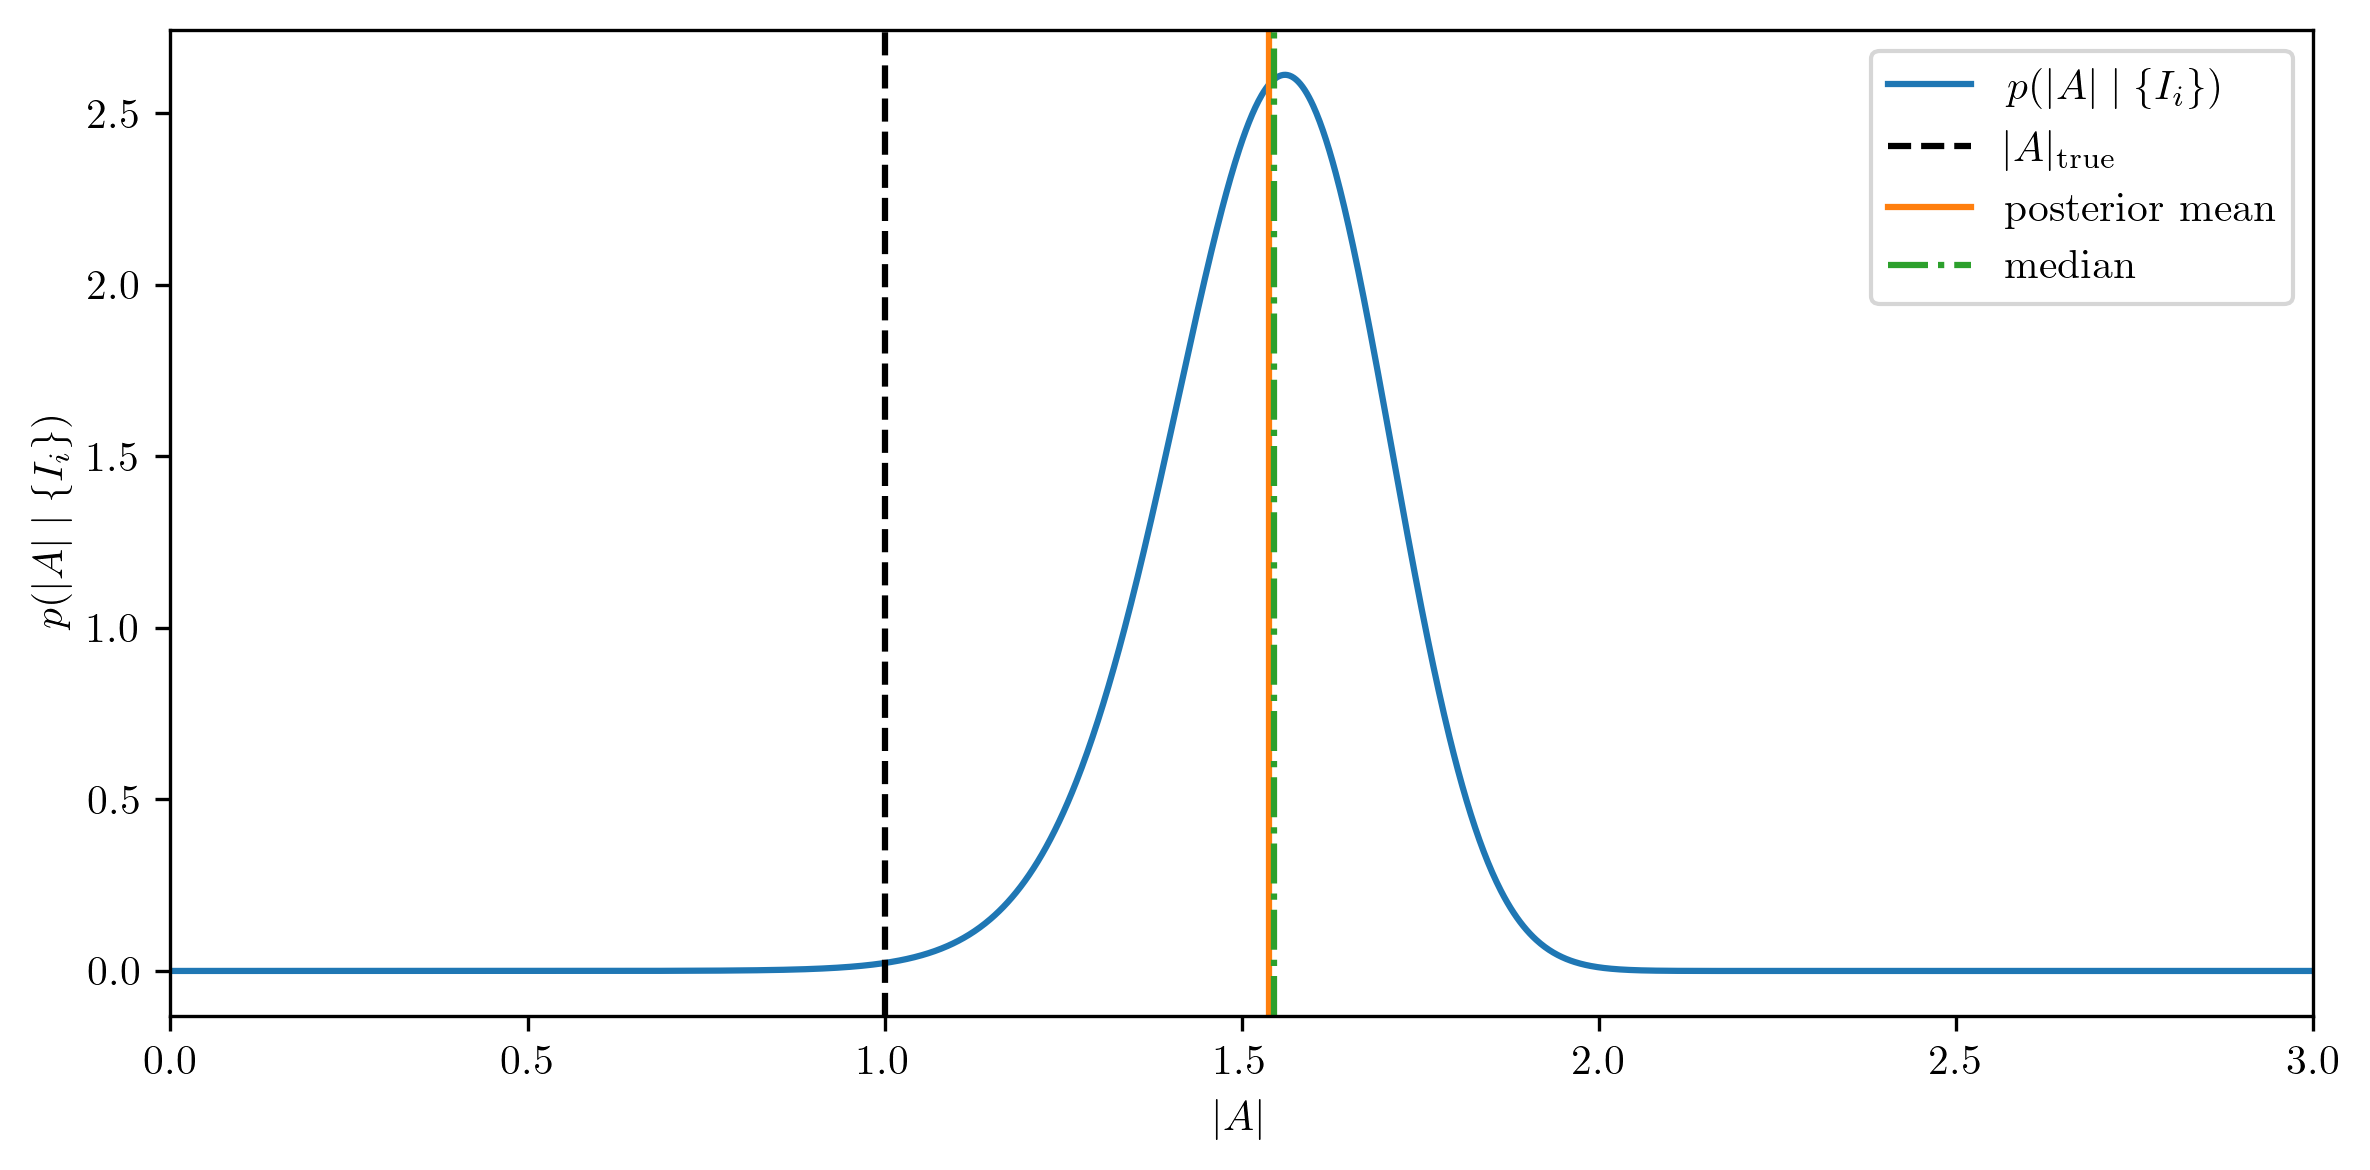

Posterior mean (|A|) = 1.5375
Posterior std  (|A|) = 0.1564
Percentiles 16/50/84 (|A|) = [1.3844, 1.5454, 1.6912]


In [64]:
# NOTE: EDIT BELOW to implement the tasks
# Infer absolute amplitude |A| with Jeffreys' prior p(|A|) ∝ |A| on [0, 3]

# Grid for |A|
r_grid = np.linspace(0.0, 3.0, 2000)
eps = 1e-12

# Model: I_i sim N(r^2, sigma_I^2)
r2 = r_grid[None, :]**2
I = np.asarray(intensity_data)
# sigma_I may be scalar
if np.ndim(sigma_I) == 0:
    sigma2 = np.full(I.shape, sigma_I**2)
else:
    sigma2 = np.asarray(sigma_I)**2

# Log-likelihood (up to additive constant)
resid2 = (I[:, None] - r2)**2
loglike = -0.5 * np.sum(resid2 / sigma2[:, None], axis=0)

# Jeffreys' prior for |A|: p(r) propto r  -> logprior = log(r)
logprior = np.log(r_grid + eps)

logpost = loglike + logprior
logpost -= np.max(logpost)
post_r = np.exp(logpost)
post_r /= np.trapezoid(post_r, r_grid)

# Posterior moments
mu_r = np.trapezoid(r_grid * post_r, r_grid)
var_r = np.trapezoid((r_grid - mu_r)**2 * post_r, r_grid)
sigma_r = np.sqrt(var_r)

# Percentiles 16,50,84
p16_r, p50_r, p84_r = compute_percentile(r_grid, post_r, percentiles=[16, 50, 84])

# Plot posterior for |A|
plt.figure(figsize=(8,4))
plt.plot(r_grid, post_r, label=r'$p(|A|\mid\{I_i\})$')
plt.axvline(abs(A_true), color='k', linestyle='--', label=r'$|A|_{\rm true}$')
plt.axvline(mu_r, color='C1', linestyle='-', label='posterior mean')
plt.axvline(p50_r, color='C2', linestyle='-.', label='median')
plt.xlim(0, 3)
plt.xlabel(r'$|A|$')
plt.ylabel(r'$p(|A|\mid\{I_i\})$')
plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Posterior mean (|A|) = {mu_r:.4f}")
print(f"Posterior std  (|A|) = {sigma_r:.4f}")
print(f"Percentiles 16/50/84 (|A|) = [{p16_r:.4f}, {p50_r:.4f}, {p84_r:.4f}]")

#### Question 3.3: Infer the intensity directly

We can also infer the intensity $I$ directly from the measurements. The Jeffreys' prior for $I$ is flat: $p(I)$ is constant.

**Tasks:**
1. Infer the intensity $I$ directly from the measurements using a flat prior on $I$ in the range $[0, 9]$.
2. Plot the posterior distribution of $I$, and compute the posterior mean, standard deviation, and 16-50-84 percentiles.
3. Convert the summary statistics of $I$ to those of $\sqrt{I}$, and compare with the results from Question 3.2.
4. Discuss your observations for all the questions in this exercise.

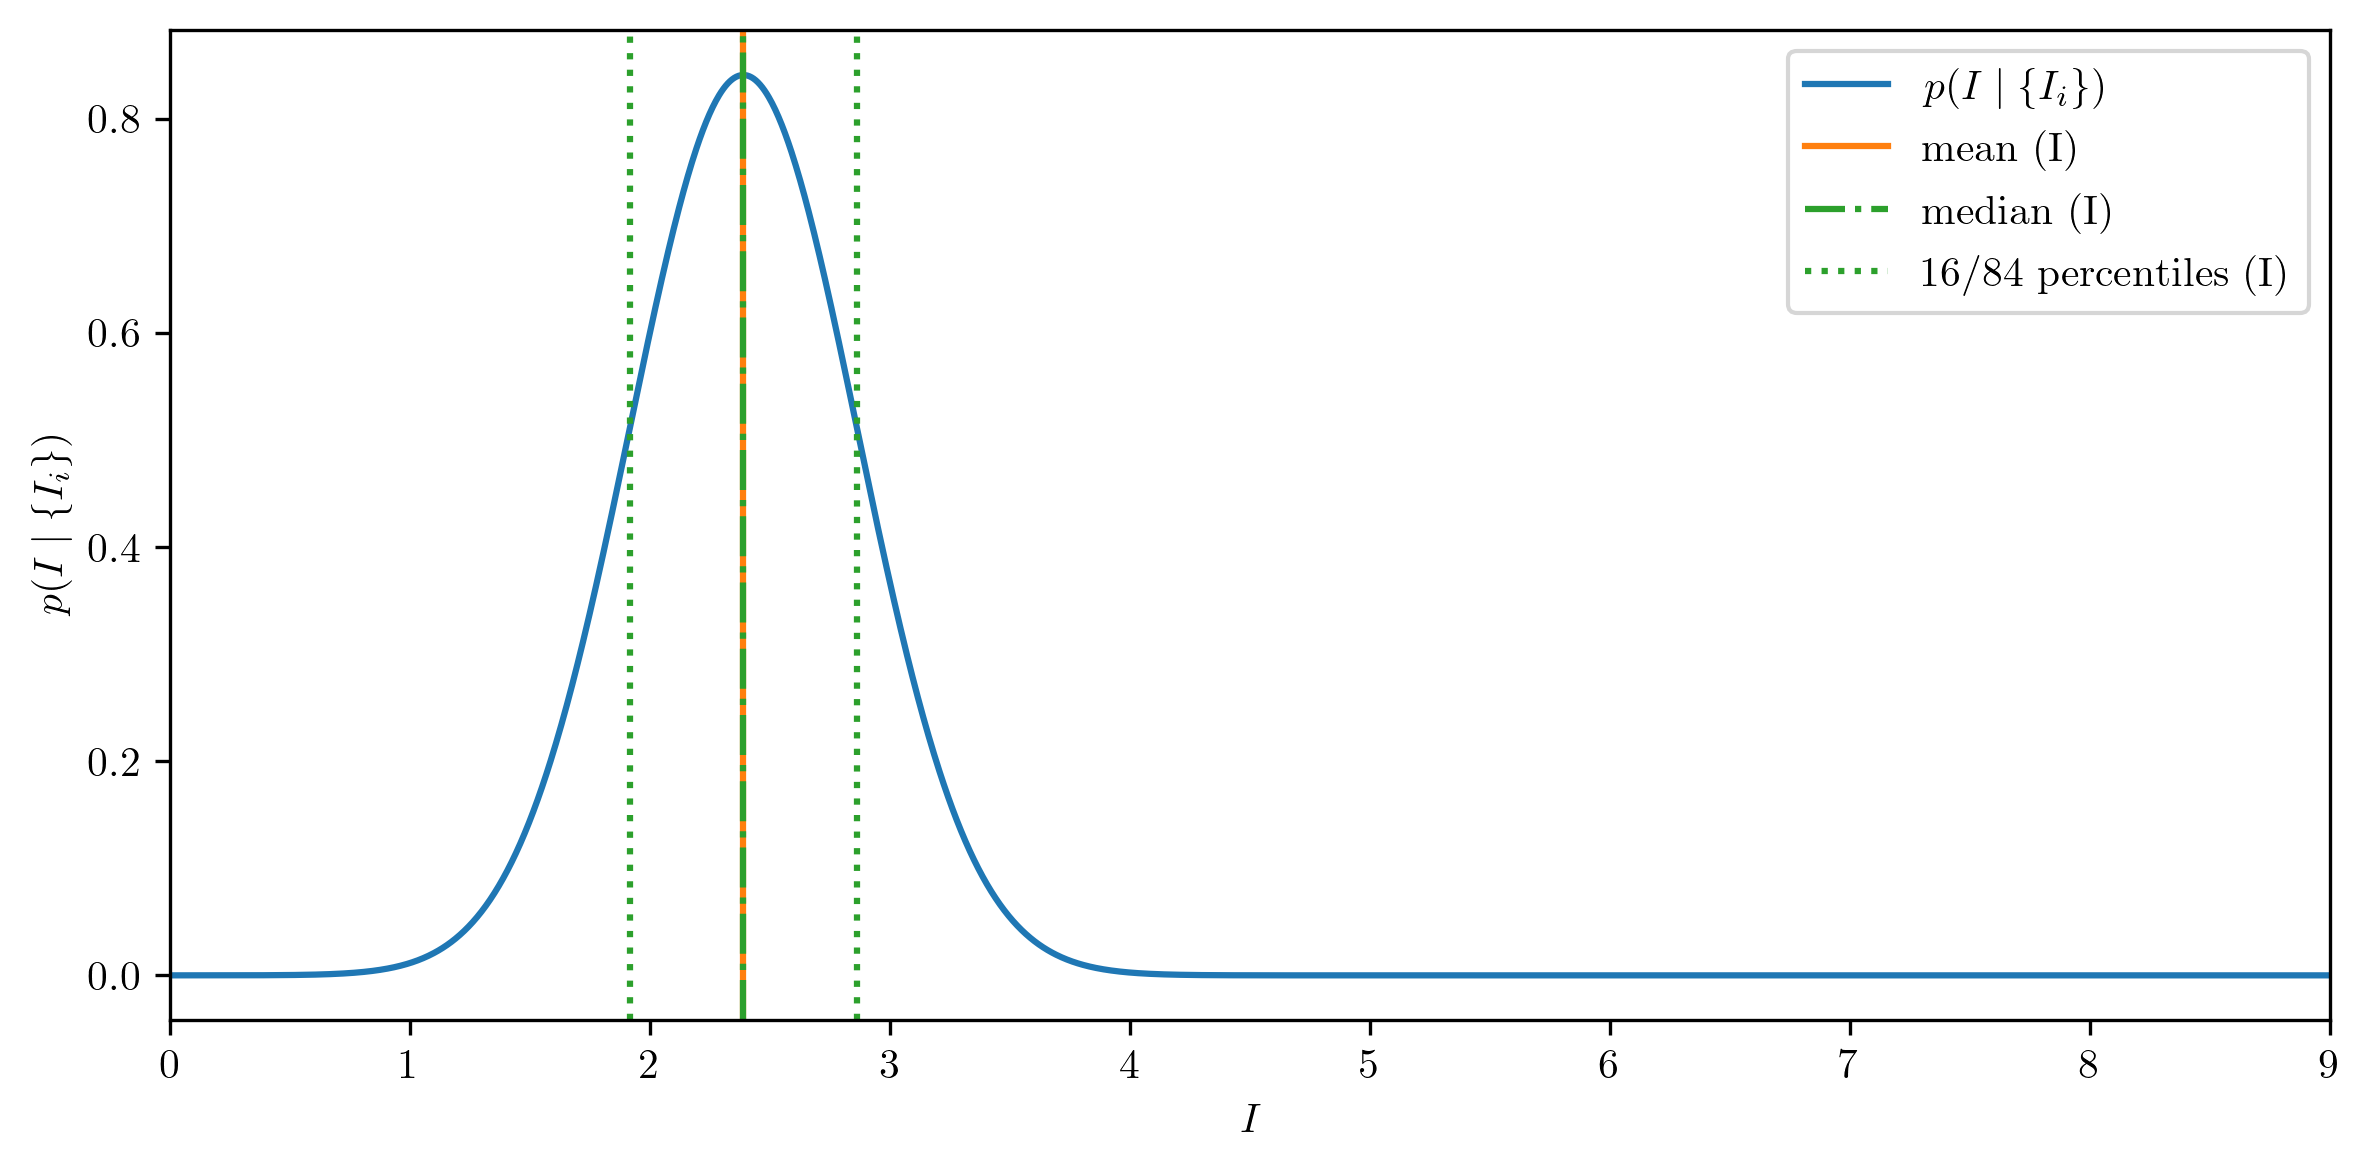

Posterior for I (flat prior on [0,9]):
  mean(I) = 2.3883, std(I) = 0.4743
  Percentiles I 16/50/84 = [1.9166, 2.3883, 2.8600]

Converted to sqrt(I):
  mean(sqrt(I)) [integral] = 1.5375, std(sqrt(I)) = 0.1564
  Percentiles sqrt(I) from I-percentiles = [1.3844, 1.5454, 1.6912]

Comparison with |A| inference (Question 3.2):
  |A| posterior mean = 1.5375, std = 0.1564, 16/50/84 = [1.3844, 1.5454, 1.6912]

Discussion summary:
- The posterior for I is directly obtained from the Gaussian likelihood; transforming to sqrt(I) via expectation gives mean/std that can be compared to the |A| posterior computed earlier.
- Percentiles converted by sqrt(percentile_I) are a simple nonlinear mapping; the mean/std of sqrt(I) need to be computed by integration and may differ from sqrt(mean(I)).
- Compare printed numbers to assess consistency between direct |A| inference and transform-from-I.


In [ ]:
# NOTE: EDIT BELOW to implement the tasks
# Infer intensity I directly from the measurements using a flat prior on [0, 9]

I_grid = np.linspace(0.0, 9.0, 2000)
I_obs = np.asarray(intensity_data)
# measurement variance (sigma_I defined earlier)
sigma2 = np.full(I_obs.shape, sigma_I**2)

# Log-likelihood (up to additive constant)
resid2 = (I_obs[:, None] - I_grid[None, :])**2
loglike = -0.5 * np.sum(resid2 / sigma2[:, None], axis=0)

# flat prior => logprior = 0
logpost = loglike
logpost -= np.max(logpost) # numerical stability
post_I = np.exp(logpost)
post_I /= np.trapezoid(post_I, I_grid)  # normalize

# Posterior moments for I
mu_I = np.trapezoid(I_grid * post_I, I_grid)
var_I = np.trapezoid((I_grid - mu_I)**2 * post_I, I_grid)
sigma_I_post = np.sqrt(var_I)

# Percentiles for I (16, 50, 84)
p16_I, p50_I, p84_I = compute_percentile(I_grid, post_I, percentiles=[16, 50, 84])

# Convert summary statistics of I to those of sqrt(I)
sqrt_I_grid = np.sqrt(I_grid)
mu_sqrt_from_integral = np.trapezoid(sqrt_I_grid * post_I, I_grid)
var_sqrt_from_integral = np.trapezoid((sqrt_I_grid - mu_sqrt_from_integral)**2 * post_I, I_grid)
sigma_sqrt_from_integral = np.sqrt(var_sqrt_from_integral)

# Convert percentiles by taking sqrt of intensity percentiles
p16_sqrt = np.sqrt(max(p16_I, 0.0))
p50_sqrt = np.sqrt(max(p50_I, 0.0))
p84_sqrt = np.sqrt(max(p84_I, 0.0))

# Plot posterior for I
plt.figure(figsize=(8,4))
plt.plot(I_grid, post_I, label=r'$p(I\mid\{I_i\})$')
plt.axvline(mu_I, color='C1', linestyle='-', label='mean (I)')
plt.axvline(p50_I, color='C2', linestyle='-.', label='median (I)')
plt.axvline(p16_I, color='C2', linestyle=':', label='16/84 percentiles (I)')
plt.axvline(p84_I, color='C2', linestyle=':')
plt.xlim(0, 9)
plt.xlabel(r'$I$')
plt.ylabel(r'$p(I\mid\{I_i\})$')
plt.legend()
plt.tight_layout()
plt.show()

# Print results and compare with |A| results from Question 3.2 (mu_r, sigma_r, p16_r, p50_r, p84_r)
print("Posterior for I (flat prior on [0,9]):")
print(f"  mean(I) = {mu_I:.4f}, std(I) = {sigma_I_post:.4f}")
print(f"  Percentiles I 16/50/84 = [{p16_I:.4f}, {p50_I:.4f}, {p84_I:.4f}]")
print()
print("Converted to sqrt(I):")
print(f"  mean(sqrt(I)) [integral] = {mu_sqrt_from_integral:.4f}, std(sqrt(I)) = {sigma_sqrt_from_integral:.4f}")
print(f"  Percentiles sqrt(I) from I-percentiles = [{p16_sqrt:.4f}, {p50_sqrt:.4f}, {p84_sqrt:.4f}]")
print()
print("Comparison with |A| inference (Question 3.2):")
print(f"  |A| posterior mean = {mu_r:.4f}, std = {sigma_r:.4f}, 16/50/84 = [{p16_r:.4f}, {p50_r:.4f}, {p84_r:.4f}]")

# Short discussion (can be expanded in the markdown cell)
print("\nDiscussion summary:")
print("- The posterior for I is directly obtained from the Gaussian likelihood; transforming to sqrt(I) "
    "via expectation gives mean/std that can be compared to the |A| posterior computed earlier.")
print("- Percentiles converted by sqrt(percentile_I) are a simple nonlinear mapping; the mean/std of sqrt(I) "
    "need to be computed by integration and may differ from sqrt(mean(I)).")
print("- Compare printed numbers to assess consistency between direct |A| inference and transform-from-I.")

##### Discussions

在题目所给的这种情况下，中值估计和平均值估计的差别并不大，而且不同的先验对结果影响还是没有那么强；在有对称双峰的情况下，对绝对值做出估计能够使得均值估计和中值估计有更高的准确程度.

### Note: steps for submitting the exercise

1. In the menu bar, select `File > Download` to download your notebook as a `.ipynb` file.
2. Select `File > Save and Export Notebook As > PDF` to export your notebook as a PDF file.
3. Combine the `.ipynb` and `.pdf` files into a single `.zip` or `.tar.gz` archive.
4. Upload your archive to the web learning platform (网络学堂).